<a href="https://colab.research.google.com/github/satvik-dixit/explainability_SER/blob/main/notebooks/explainability_SER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainability of DL-based embeddings




### Importing packages

In [ ]:
!pip install -q tqdm
!pip install -q opensmile
!pip install -q torch torchaudio transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.4/167.4 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.2/996.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.3/151.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 kB 4.8 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
from tqdm import tqdm
from glob import glob
from random import sample
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
import random
import torch
import opensmile
import seaborn as sns

from sklearn.svm import SVC, SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, ElasticNet, LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score, GroupShuffleSplit
from sklearn.metrics import classification_report, f1_score, make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
f1 = make_scorer(f1_score, average='weighted')
from transformers import AutoFeatureExtractor, AutoModel

import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Upload kaggle.json to download the EmoDB dataset

! pip install -q kaggle

from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


## Loading audio files and extracting metadata

Includes downloading the dataset, loading audio files, resampling audio files, extracting metadata



### Defining a function for loading and resampling audio files

In [ ]:
np.random.seed(42)

# Defining a function for loading and resampling audio files

def load_audio_files(audio_files, resampling_frequency=16000, audio_list=None):
  '''
  Loads and resamples audio files

  Parameters
  ------------
  audio_files: string
      The paths of the wav files
  resampling_frequency: integer
      The frequency which all audios will be resampled to
  audio_list: list
      The list of torch tensors of audios to which more audios need too be added, empty by default

  Returns
  ------------
  audio_list: list
      A list of torch tensors, one array for each audio file

  '''
  # Making audio_list
  if audio_list is None:
    audio_list = []

  # Resampling
  for audio in audio_files:
    signal, fs = librosa.load(audio, sr=resampling_frequency)
    audio_list.append(torch.from_numpy(signal))

  return audio_list


### Loading and resampling audiofiles and collecting metadata on EmoDB dataset

In [ ]:
from pathlib import Path
from collections import Counter

# Phase_1
# Load dataset
! kaggle datasets download -q -d uwrfkaggler/ravdess-emotional-speech-audio
! unzip -q ravdess-emotional-speech-audio.zip -d '/content/ravdess'

# Select all the audio files
audios = []
for file in Path('/content/ravdess/audio_speech_actors_01-24').glob("**/*.wav"):
    if not file.is_file():
        continue
    audios.append(str(file))

# Load and resample audio files
audio_list = load_audio_files(audios, resampling_frequency=16000)

# Making speakers list and labels list
speakers = []
labels = []
for audio_file in audios:
  file_name = audio_file.split('/')[5]
  speakers.append(file_name[18:20])
  labels.append(file_name[6:8])

label_dict = {'01': 'neutrality', '02': 'calm', '03': 'joy', '04': 'sadness', '05': 'anger', '06': 'fear', '07': 'disgust', '08': 'surprise'}
labels = [label_dict[emotion] for emotion in labels]

# Verify phase_1
print('Number of audio files: {}'.format(len(audio_list)))
print('Number of speaker classes: {}'.format(len(set(speakers))))
print('Speaker classes: {}'.format(set(speakers)))
print('Number of speakers: {}'.format(len(speakers)))
print('Number of label classes: {}'.format(len(set(labels))))
print('Label classes: {}'.format(set(labels)))
print('Number of labels: {}'.format(len(labels)))
frequency_dict = Counter(labels)
print('frequency dict:', frequency_dict)

Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
Number of audio files: 1440
Number of speaker classes: 24
Speaker classes: {'14', '11', '12', '04', '22', '23', '16', '07', '13', '15', '05', '09', '21', '06', '03', '01', '19', '08', '10', '18', '24', '17', '02', '20'}
Number of speakers: 1440
Number of label classes: 8
Label classes: {'anger', 'fear', 'sadness', 'calm', 'neutrality', 'disgust', 'surprise', 'joy'}
Number of labels: 1440
frequency dict: Counter({'anger': 192, 'disgust': 192, 'sadness': 192, 'joy': 192, 'calm': 192, 'fear': 192, 'surprise': 192, 'neutrality': 96})


## Embedding Extraction
Includes extracting features using
- Deep learning based methods: WavLM
- DSP based methods: openSMILE eGeMAPS

### Audio embeddings extraction functions

In [ ]:
# Defining a function for generating audio embedding extraction models

def audio_embeddings_model(model_name):
    '''
    Generates model for embedding extraction

    Parameters
    ------------
    mode_name: string
        The model to used, could be 'hybrid_byols', 'compare' or 'egemaps'

    Returns
    ------------
    model: object
        The embedding extraction model
    '''
    if model_name=='compare':
        model = opensmile.Smile(
            feature_set=opensmile.FeatureSet.ComParE_2016,
            feature_level=opensmile.FeatureLevel.Functionals,
        )
    elif model_name=='egemaps':
        model = opensmile.Smile(
            feature_set=opensmile.FeatureSet.eGeMAPSv02,
            feature_level=opensmile.FeatureLevel.Functionals,
        )
    return model


# Defining a function for embedding exctraction from the audio list

def audio_embeddings(audio_list, model_name, model, sampling_rate=16000):
    '''
    Loads and resamples audio files

    Parameters
    ------------
    audio_list: list
        A list of arrays, one array for each audio file
    model_name: string
        The model to used, could be 'hybrid_byols', 'compare' or 'egemaps'
    model: object
        The embedding extraction model generated by audio_embeddings_model function
    sampling_rate: int
        The sampling rate, 16 kHz by default

    Returns
    ------------
    embeddings_array: array
        The array containg embeddings of all audio_files, dimension (number of audio files × n_feats)

    '''

    embeddings_list = []
    for i in tqdm(range(len(audio_list))):
        embeddings = model.process_signal(audio_list[i], sampling_rate)
        embeddings_list.append(torch.tensor(embeddings.values[0], dtype=torch.float32))
    embeddings_array = torch.stack(embeddings_list)
    return embeddings_array


def audio_embeddings_wavlm(audio_list, sampling_rate=16000):
  """
  Extracts embeddings from audio list using WavLM.

  Args:
      audio_list: List of audio file paths or audio data arrays.
      sampling_rate: Sampling rate of the audio (default: 16000).

  Returns:
      torch.Tensor: Embeddings for each audio file in the list.
  """
  embeddings_list = []
  for audio in tqdm(audio_list):

      inputs = feature_extractor(audio, sampling_rate=sampling_rate, return_tensors="pt")

      with torch.no_grad():
          outputs = model(**inputs)
          embeddings = outputs.last_hidden_state
          embeddings = torch.mean(embeddings, dim=1)
      embeddings_list.append(embeddings)

  return torch.cat(embeddings_list, dim=0)


def get_egemaps_feature_names():
    model = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
    egemaps_feature_names = model.column_names

    return egemaps_feature_names



In [ ]:
egemaps_feature_names = get_egemaps_feature_names()
def remove_substring(strings, target):
    return [s.replace(target, '') for s in strings]

# egemaps_feature_names = remove_substring(egemaps_feature_names, '_sma3nz')
# egemaps_feature_names = remove_substring(egemaps_feature_names, '_sma3')
print(egemaps_feature_names)

Index(['F0semitoneFrom27.5Hz_sma3nz_amean',
       'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
       'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
       'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
       'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
       'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
       'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope', 'loudness_sma3_amean',
       'loudness_sma3_stddevNorm', 'loudness_sma3_percentile20.0',
       'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0',
       'loudness_sma3_pctlrange0-2', 'loudness_sma3_meanRisingSlope',
       'loudness_sma3_stddevRisingSlope', 'loudness_sma3_meanFallingSlope',
       'loudness_sma3_stddevFallingSlope', 'spectralFlux_sma3_amean',
       'spectralFlux_sma3_stddevNorm', 'mfcc1_sma3_amean',
       'mfcc1_sma3_stddevNorm', 'mfcc2_

### Audio embeddings extraction on EmoDB

In [ ]:
# WavLM
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/wavlm-large")
model = AutoModel.from_pretrained("microsoft/wavlm-large")
embeddings_array_WavLM = audio_embeddings_wavlm(audio_list)
# embeddings_array_WavLM = np.load("wavlm_embeddings_ravdess.npy")
print(embeddings_array_WavLM.shape)

# EmoDB egemaps
model = audio_embeddings_model(model_name='egemaps')
embeddings_array_egemaps = audio_embeddings(audio_list, model_name='egemaps', model=model)

# ---------------------------------------------------------------------------------------------------

# Verify Phase_2
models = ['WavLM', 'egemaps']
embeddings_arrays = {'WavLM': embeddings_array_WavLM, 'egemaps':embeddings_array_egemaps}

for model in models:
  print()
  print()
  print('MODEL: {}'.format(model))
  print()
  print('The shape of the embeddings array is {}'.format(embeddings_arrays[model].shape))


preprocessor_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.22k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/wavlm-large were not used when initializing WavLMModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing WavLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing WavLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of WavLMModel were not initialized from the model checkpoint at microsoft/wavlm-large and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and i

torch.Size([1440, 1024])


100%|██████████| 1440/1440 [04:00<00:00,  5.98it/s]



MODEL: WavLM

The shape of the embeddings array is torch.Size([1440, 1024])


MODEL: egemaps

The shape of the embeddings array is torch.Size([1440, 88])


In [ ]:

# Defining a function for speaker normalisation using standard scaler

def speaker_normalisation(embeddings_array, speakers):
    '''
    Normalises embeddings_array for each speaker

    Parameters
    ------------
    embeddings_array: array
        The array of embeddings, one row for each audio file
    speakers: list
        The list of speakers

    Returns
    ------------
    embeddings_array: array
        The array containg normalised embeddings of all audio_files, dimension (number of audio files × n_feats)

    '''
    speaker_ids = set(speakers)
    for speaker_id in speaker_ids:
        speaker_embeddings_indices = np.where(np.array(speakers)==speaker_id)[0]
        speaker_embeddings = embeddings_array[speaker_embeddings_indices,:]
        scaler = StandardScaler()
        normalised_speaker_embeddings = scaler.fit_transform(speaker_embeddings)
        embeddings_array[speaker_embeddings_indices] = torch.tensor(normalised_speaker_embeddings).float()
    return embeddings_array

embeddings_arrays['WavLM'] = speaker_normalisation(embeddings_arrays['WavLM'], speakers)
embeddings_arrays['egemaps'] = speaker_normalisation(embeddings_arrays['egemaps'], speakers)


# Classification + SHAP Code
Code for the classification task and getting the SHAP feature importance for every eGeMAPS feature and every WaVLM embedding dimension for each emotion


In [ ]:
# function for dividing the dataset into dictionaries with emotions as keys and embeddings/labels/speakers as values

def label_division(embeddings_array, labels, required_labels, speakers):
    np.random.seed(42)
    final_embeddings_dict = {}
    final_labels_dict = {}
    final_speakers_list_dict = {}

    for label in required_labels:
        label_indices = np.where(np.array(labels) == label)[0]
        label_embeddings = embeddings_array[label_indices, :]
        final_speakers_list_dict[label] = list(np.array(speakers)[label_indices])
        final_embeddings_dict[label] = label_embeddings
        final_labels_dict[label] = [label] * len(label_indices)

    return final_embeddings_dict, final_labels_dict, final_speakers_list_dict


In [ ]:
# function for combining one emotion (50%) and the rest of the 5 emotions (10% each)

def emotion_all_merger(emotion, other_emotions, wavlm_embeddings_dict, egemaps_embeddings_dict, speakers_dict, num=96):

  np.random.seed(42)
  print(len(speakers_dict[emotion]), num)
  emo_indices = np.random.choice(len(speakers_dict[emotion]), size=num, replace=False)

  wavlm_embeddings = wavlm_embeddings_dict[emotion][emo_indices]
  egemaps_embeddings = egemaps_embeddings_dict[emotion][emo_indices]
  speakers = [speakers_dict[emotion][i] for i in emo_indices]
  labels = [1]*num

  for em in other_emotions:
    em_indices = np.random.choice(len(speakers_dict[em]), size=int(num/len(other_emotions)), replace=False)
    em_speakers = [speakers_dict[em][i] for i in em_indices]
    wavlm_embeddings_emo = wavlm_embeddings_dict[em][em_indices]
    egemaps_embeddings_emo = egemaps_embeddings_dict[em][em_indices]
    # print('egemaps_embeddings_emo.shape', egemaps_embeddings_emo.shape)
    # print('wavlm_embeddings_emo.shape', wavlm_embeddings_emo.shape)

    wavlm_embeddings = np.concatenate((wavlm_embeddings, wavlm_embeddings_emo), axis=0)
    egemaps_embeddings = np.concatenate((egemaps_embeddings, egemaps_embeddings_emo), axis=0)
    # print('w_embeddings.shape', w_embeddings.shape)
    # print('e_embeddings.shape', e_embeddings.shape)

    speakers = speakers + em_speakers
    labels = labels + [0]*int(num/len(other_emotions))

  return wavlm_embeddings, egemaps_embeddings, labels, speakers


In [ ]:
wavlm_embeddings_dict, wavlm_labels_dict, wavlm_speakers_list_dict = label_division(embeddings_array=embeddings_array_WavLM, labels=labels, required_labels=['anger', 'fear', 'neutrality', 'joy', 'sadness', 'disgust'], speakers=speakers)
eGeMAPS_embeddings_dict, eGeMAPS_labels_dict, eGeMAPS_speakers_list_dict = label_division(embeddings_array=embeddings_array_egemaps, labels=labels, required_labels=['anger', 'fear', 'neutrality', 'joy', 'sadness', 'disgust'], speakers=speakers)

emotions = ['anger', 'fear', 'neutrality', 'joy', 'sadness', 'disgust']

wavlm_embeddings_all = {}
egemaps_embeddings_all = {}
speakers_all = {}
labels_all = {}

for e in emotions:
    wavlm_embeddings, egemaps_embeddings, labels, speakers = emotion_all_merger(emotion=e, other_emotions=['neutrality'], wavlm_embeddings_dict=wavlm_embeddings_dict, egemaps_embeddings_dict=eGeMAPS_embeddings_dict, speakers_dict=eGeMAPS_speakers_list_dict, num=96)
    wavlm_embeddings_all[e] = wavlm_embeddings
    egemaps_embeddings_all[e] = egemaps_embeddings
    speakers_all[e] = speakers
    labels_all[e] = labels
    print(e)
    print('-'*20)
    print('speakers:', speakers)
    print('labels_all:', labels_all)
    print()


192 96
anger
--------------------
speakers: ['12', '19', '03', '19', '17', '06', '21', '23', '23', '21', '03', '17', '13', '13', '09', '24', '04', '13', '07', '13', '16', '09', '17', '01', '13', '17', '24', '09', '22', '19', '17', '11', '23', '18', '16', '14', '20', '19', '11', '10', '07', '11', '05', '20', '12', '06', '01', '02', '03', '15', '24', '09', '22', '02', '11', '05', '24', '09', '21', '12', '09', '08', '08', '01', '24', '15', '10', '18', '14', '12', '01', '18', '20', '05', '06', '23', '06', '17', '15', '21', '17', '09', '14', '24', '07', '14', '05', '15', '19', '15', '19', '21', '22', '01', '19', '14', '23', '12', '24', '24', '01', '24', '15', '04', '03', '13', '18', '06', '19', '01', '21', '14', '21', '04', '18', '12', '18', '17', '10', '09', '19', '08', '15', '22', '23', '10', '02', '16', '21', '08', '18', '11', '15', '04', '04', '13', '22', '22', '12', '02', '02', '09', '11', '01', '05', '08', '03', '13', '10', '08', '21', '09', '20', '15', '20', '02', '11', '13', '20', '

In [ ]:
!pip install -q shap

import shap
import numpy as np
import matplotlib.pyplot as plt

def feature_importance_method(X, y, feature_names, trained_model):
    # Create a SHAP explainer
    explainer = shap.Explainer(trained_model, X)

    # Calculate SHAP values
    shap_values = explainer(X)

    # Get the mean absolute SHAP values for each feature
    shap_mean_abs = np.mean(np.abs(shap_values.values), axis=0)

    # Get the indices of the sorted feature importances
    feature_indices = np.argsort(shap_mean_abs)[::-1]

    # Create a list of sorted feature importances
    sorted_importances = [(feature_names[i], shap_mean_abs[i]) for i in feature_indices]

    # Plot SHAP feature importance
    shap.summary_plot(shap_values, X, feature_names=feature_names, plot_type='bar')

    return sorted_importances


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 4.2 MB/s eta 0:00:00


In [ ]:
# Function for nested cross validation

emotions = ['anger', 'fear', 'neutrality', 'joy', 'sadness', 'disgust']
Performance ={'eGeMAPS':{e:[] for e in emotions}, 'WavLM_all':{e:[] for e in emotions}, 'WavLM_top_features':{e:[] for e in emotions}}

def classification_pipeline(embeddings, speakers, labels_list, feature_names):

    np.random.seed(42)

    X = embeddings
    y = labels_list
    groups = speakers

    param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

    # Outer cross-validation loop
    outer_cv = GroupShuffleSplit(n_splits=5, train_size=0.8, random_state=42)
    outer_scores = []
    feats_array = []
    for train_index, test_index in outer_cv.split(X, y, groups):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]

        # Inner cross-validation loop for hyperparameter tuning
        inner_cv = GroupShuffleSplit(n_splits=5, train_size=0.8, random_state=42)
        grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=inner_cv)
        grid_search.fit(X_train, y_train, groups=[groups[i] for i in train_index])

        # Get the best hyperparameters found in the inner loop
        best_params = grid_search.best_params_

        # Fit the model with the best hyperparameters on the training data
        model = LogisticRegression( **best_params)

        # Standardize X_train and transform X_test
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model.fit(X_train, y_train)

        # Evaluate the model on the test data
        y_pred = model.predict(X_test)
        score = f1_score(y_test, y_pred, average='binary')
        outer_scores.append(score)

    # Compute and print the mean F1 score across all outer folds
    mean_f1 = np.round(100*np.mean(outer_scores), 1)
    print('F1:', mean_f1)
    return model, mean_f1



In [ ]:
def find_x_at_n_percentile(x_values, y_values, n):
    percentile = np.percentile(y_values, n)
    for i, y in enumerate(y_values):
        if y >= percentile:
            x_at_nth_percentile = x_values[i]
            break

    return x_at_nth_percentile

# Classification + SHAP for eGeMAPS Features
Results for emotion classification (binary classification task) using eGeMAPS features. Also includes results for calculating SHAP score per feature for each emotion and identifying most important types of acoustic features (such as energy-based, spectral etc.) for every emotion

F1: 93.7


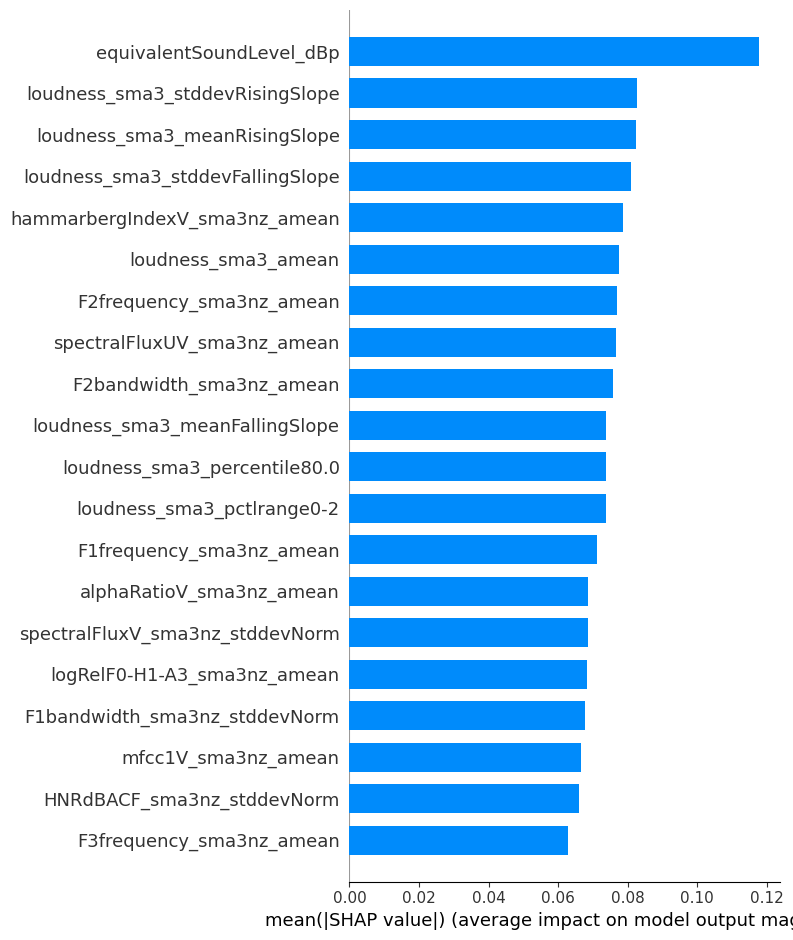

F1: 90.9


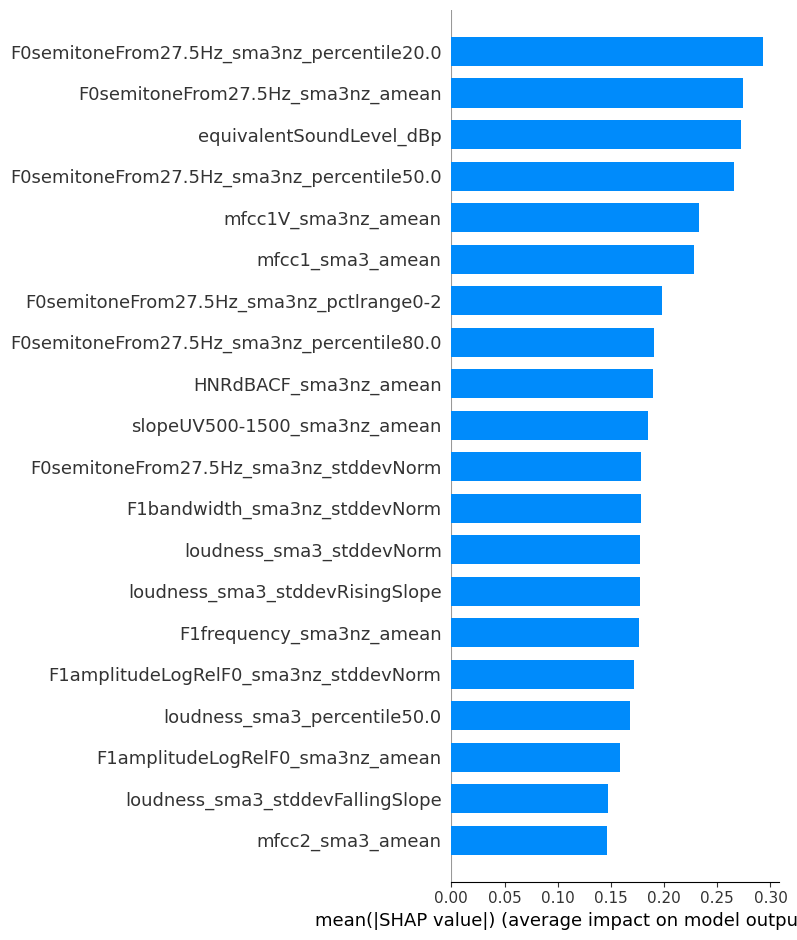

F1: 0.0


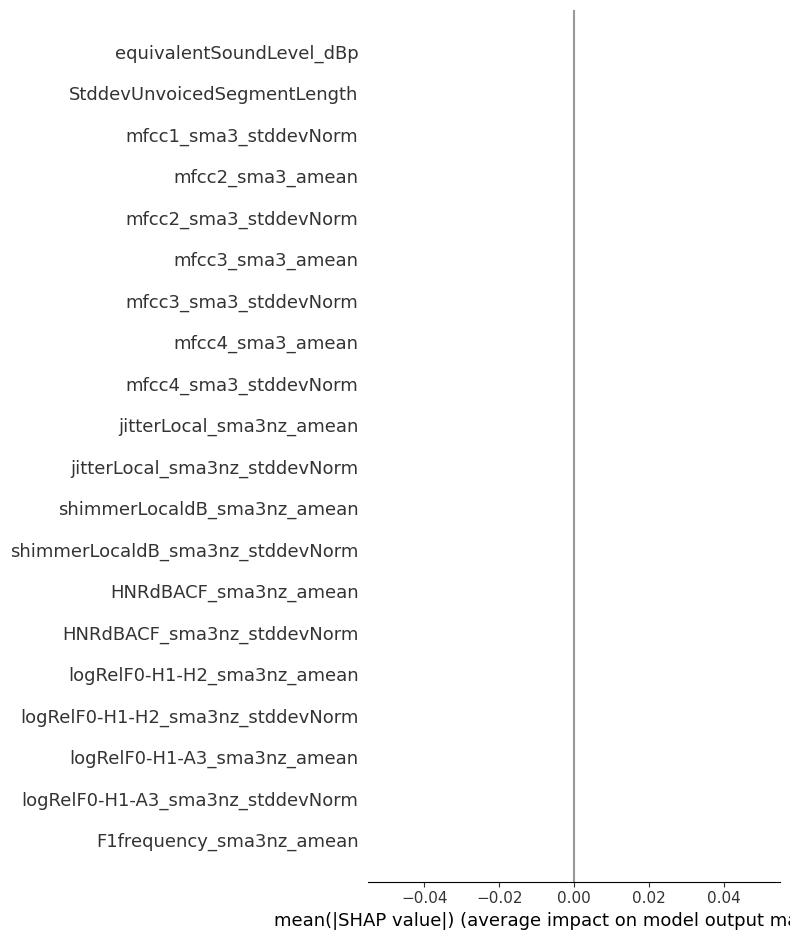

F1: 84.0


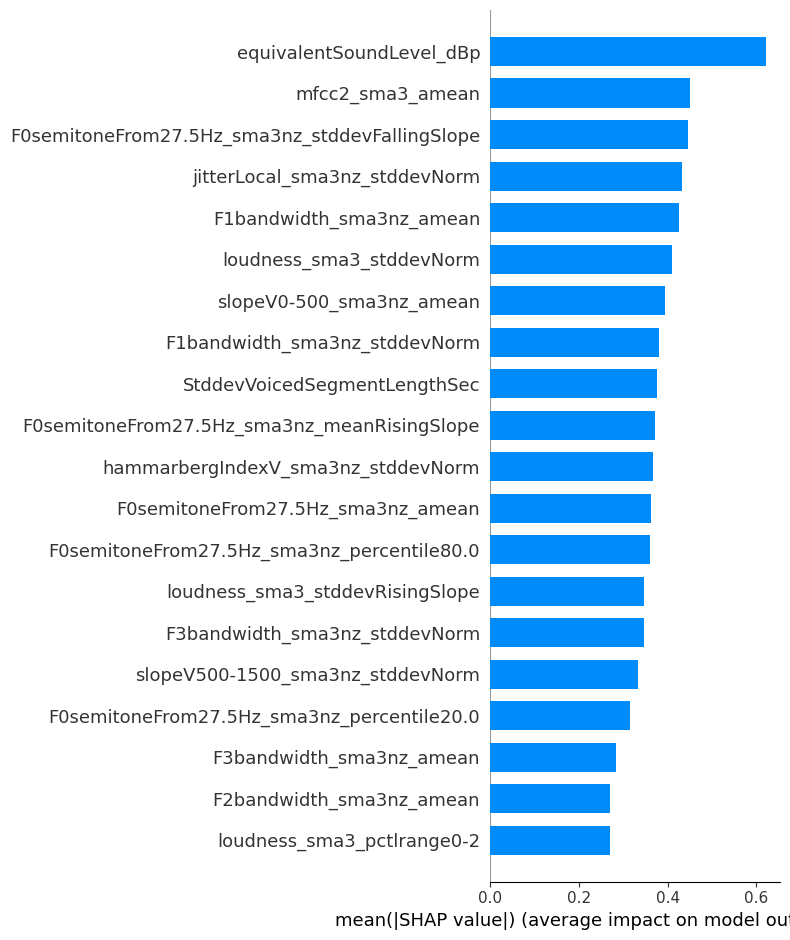

F1: 75.7


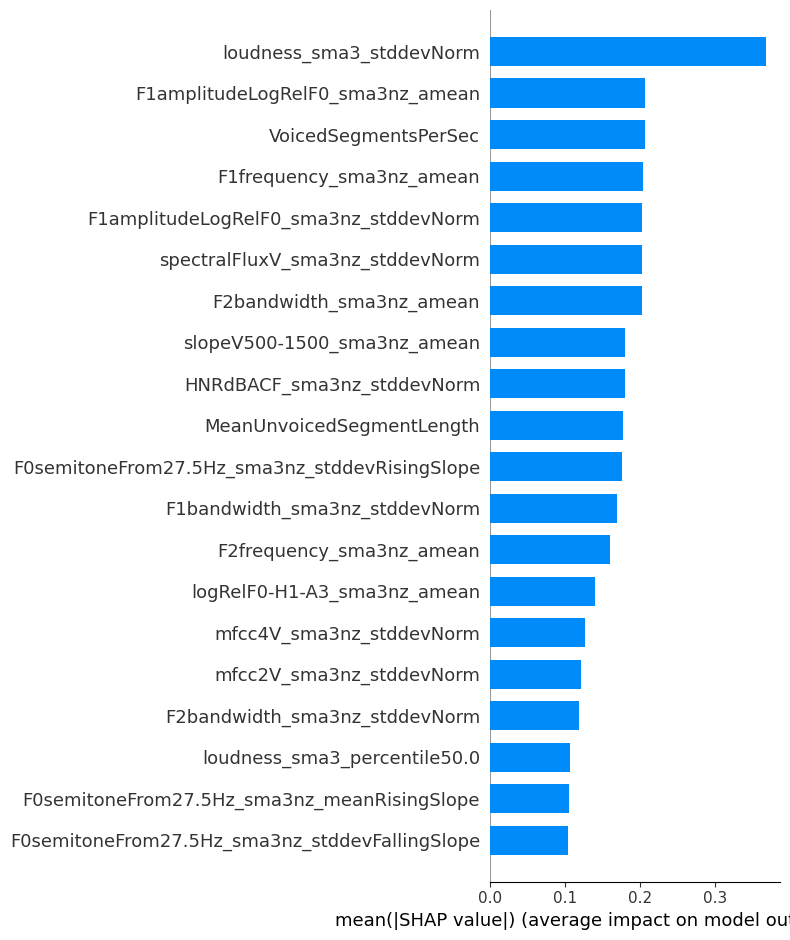

F1: 89.9


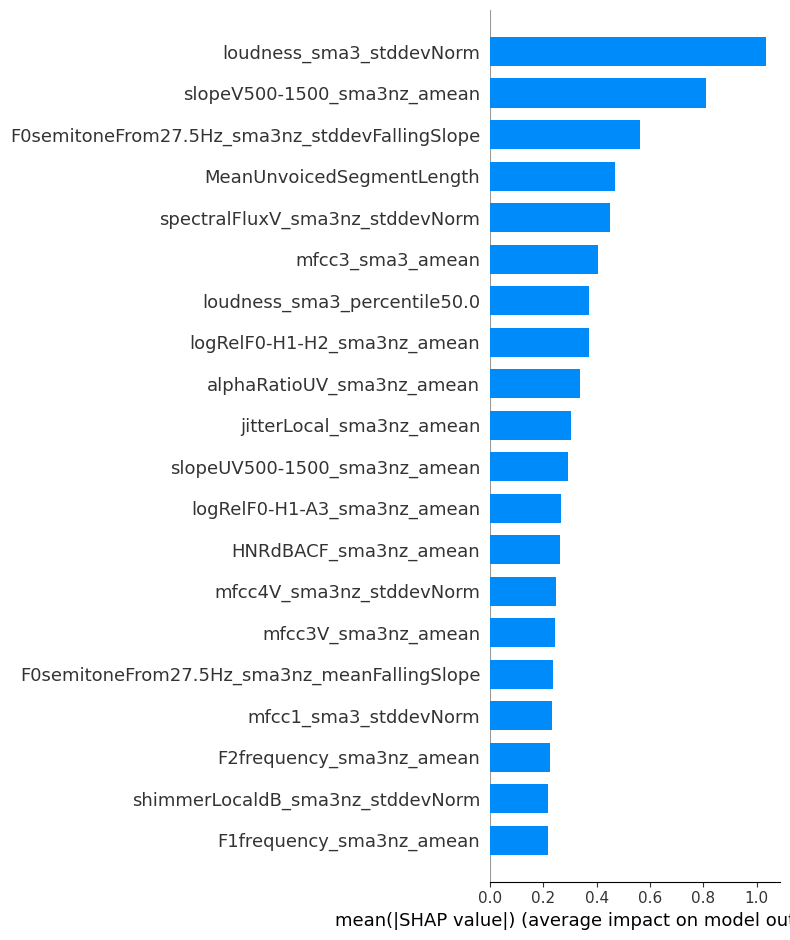

In [ ]:
eGeMAPS_fi_dict = {}
egemaps_top_features_df = {}

emotions = ['anger', 'fear', 'neutrality', 'joy', 'sadness', 'disgust']

for e in emotions:

  ege_embeddings, ege_labels, ege_speakers = egemaps_embeddings_all[e], labels_all[e], speakers_all[e]
  trained_model, result = classification_pipeline(embeddings=ege_embeddings, speakers=ege_speakers, labels_list=ege_labels, feature_names=egemaps_feature_names)
  Performance['eGeMAPS'][e] = result

  fi = feature_importance_method(X=ege_embeddings, y=ege_labels, feature_names=egemaps_feature_names, trained_model=trained_model)
#   eGeMAPS_fi_dict[e] = [list(egemaps_feature_names).index(tup[0]) for tup in fi]
  eGeMAPS_top_fi_features = [[tup[0], np.round(tup[1], 3)] for tup in fi]
  table = {'Feature': [element[0] for element in eGeMAPS_top_fi_features], 'Importance': [element[1] for element in eGeMAPS_top_fi_features]}
  egemaps_top_features_df[e] = pd.DataFrame(table)


## Most important egemaps features (according to coef)

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def process_and_save_egemaps_data(egemaps_top_features_df, egemaps_category_dict, output_dir):
    scaler = MinMaxScaler(feature_range=(0, 1))  # For normalizing importance values

    # Loop through each emotion and process its DataFrame
    for emotion, df in egemaps_top_features_df.items():
        # Map features to their categories
        df['Category'] = df['Feature'].map(egemaps_category_dict)

        # Normalize the Importance values
        df['Importance'] = scaler.fit_transform(df[['Importance']])

        # Save the processed DataFrame as a pickle file
        output_path = f'{output_dir}/{emotion}_ravdess_processed.pkl'
        df.to_pickle(output_path)
        print(f'Saved: {output_path}')


In [ ]:
egemaps_category_dict = {
    'F0semitoneFrom27.5Hz_sma3nz_amean': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_stddevNorm': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_percentile20.0': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_percentile50.0': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_percentile80.0': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope': 'Frequency',
    'jitterLocal_sma3nz_amean': 'Frequency',
    'jitterLocal_sma3nz_stddevNorm': 'Frequency',
    'shimmerLocaldB_sma3nz_amean': 'Energy',
    'shimmerLocaldB_sma3nz_stddevNorm': 'Energy',
    'loudness_sma3_amean': 'Energy',
    'loudness_sma3_stddevNorm': 'Energy',
    'loudness_sma3_percentile20.0': 'Energy',
    'loudness_sma3_percentile50.0': 'Energy',
    'loudness_sma3_percentile80.0': 'Energy',
    'loudness_sma3_pctlrange0-2': 'Energy',
    'loudness_sma3_meanRisingSlope': 'Energy',
    'loudness_sma3_stddevRisingSlope': 'Energy',
    'loudness_sma3_meanFallingSlope': 'Energy',
    'loudness_sma3_stddevFallingSlope': 'Energy',
    'HNRdBACF_sma3nz_amean': 'Energy',
    'HNRdBACF_sma3nz_stddevNorm': 'Energy',
    'spectralFlux_sma3_amean': 'Spectral',
    'spectralFlux_sma3_stddevNorm': 'Spectral',
    'mfcc1_sma3_amean': 'Spectral',
    'mfcc1_sma3_stddevNorm': 'Spectral',
    'mfcc2_sma3_amean': 'Spectral',
    'mfcc2_sma3_stddevNorm': 'Spectral',
    'mfcc3_sma3_amean': 'Spectral',
    'mfcc3_sma3_stddevNorm': 'Spectral',
    'mfcc4_sma3_amean': 'Spectral',
    'mfcc4_sma3_stddevNorm': 'Spectral',
    'logRelF0-H1-H2_sma3nz_amean': 'Spectral',
    'logRelF0-H1-H2_sma3nz_stddevNorm': 'Spectral',
    'logRelF0-H1-A3_sma3nz_amean': 'Spectral',
    'logRelF0-H1-A3_sma3nz_stddevNorm': 'Spectral',
    'F1frequency_sma3nz_amean': 'Frequency',
    'F1frequency_sma3nz_stddevNorm': 'Frequency',
    'F1bandwidth_sma3nz_amean': 'Frequency',
    'F1bandwidth_sma3nz_stddevNorm': 'Frequency',
    'F1amplitudeLogRelF0_sma3nz_amean': 'Spectral',
    'F1amplitudeLogRelF0_sma3nz_stddevNorm': 'Spectral',
    'F2frequency_sma3nz_amean': 'Frequency',
    'F2frequency_sma3nz_stddevNorm': 'Frequency',
    'F2bandwidth_sma3nz_amean': 'Frequency',
    'F2bandwidth_sma3nz_stddevNorm': 'Frequency',
    'F2amplitudeLogRelF0_sma3nz_amean': 'Spectral',
    'F2amplitudeLogRelF0_sma3nz_stddevNorm': 'Spectral',
    'F3frequency_sma3nz_amean': 'Frequency',
    'F3frequency_sma3nz_stddevNorm': 'Frequency',
    'F3bandwidth_sma3nz_amean': 'Frequency',
    'F3bandwidth_sma3nz_stddevNorm': 'Frequency',
    'F3amplitudeLogRelF0_sma3nz_amean': 'Spectral',
    'F3amplitudeLogRelF0_sma3nz_stddevNorm': 'Spectral',
    'alphaRatioV_sma3nz_amean': 'Spectral',
    'alphaRatioV_sma3nz_stddevNorm': 'Spectral',
    'hammarbergIndexV_sma3nz_amean': 'Spectral',
    'hammarbergIndexV_sma3nz_stddevNorm': 'Spectral',
    'slopeV0-500_sma3nz_amean': 'Spectral',
    'slopeV0-500_sma3nz_stddevNorm': 'Spectral',
    'slopeV500-1500_sma3nz_amean': 'Spectral',
    'slopeV500-1500_sma3nz_stddevNorm': 'Spectral',
    'spectralFluxV_sma3nz_amean': 'Spectral',
    'spectralFluxV_sma3nz_stddevNorm': 'Spectral',
    'mfcc1V_sma3nz_amean': 'Spectral',
    'mfcc1V_sma3nz_stddevNorm': 'Spectral',
    'mfcc2V_sma3nz_amean': 'Spectral',
    'mfcc2V_sma3nz_stddevNorm': 'Spectral',
    'mfcc3V_sma3nz_amean': 'Spectral',
    'mfcc3V_sma3nz_stddevNorm': 'Spectral',
    'mfcc4V_sma3nz_amean': 'Spectral',
    'mfcc4V_sma3nz_stddevNorm': 'Spectral',
    'alphaRatioUV_sma3nz_amean': 'Spectral',
    'hammarbergIndexUV_sma3nz_amean': 'Spectral',
    'slopeUV0-500_sma3nz_amean': 'Spectral',
    'slopeUV500-1500_sma3nz_amean': 'Spectral',
    'spectralFluxUV_sma3nz_amean': 'Spectral',
    'loudnessPeaksPerSec': 'Temporal',
    'VoicedSegmentsPerSec': 'Temporal',
    'MeanVoicedSegmentLengthSec': 'Temporal',
    'StddevVoicedSegmentLengthSec': 'Temporal',
    'MeanUnvoicedSegmentLength': 'Temporal',
    'StddevUnvoicedSegmentLength': 'Temporal',
    'equivalentSoundLevel_dBp': 'Energy',
}

In [ ]:
output_directory = '/content'  # Replace with your desired output directory
process_and_save_egemaps_data(egemaps_top_features_df, egemaps_category_dict, output_directory)

Saved: /content/anger_ravdess_processed.pkl
Saved: /content/fear_ravdess_processed.pkl
Saved: /content/neutrality_ravdess_processed.pkl
Saved: /content/joy_ravdess_processed.pkl
Saved: /content/sadness_ravdess_processed.pkl
Saved: /content/disgust_ravdess_processed.pkl


In [ ]:
df = egemaps_top_features_df[emotions[0]]
df.head(10)


,Feature,Importance,Category
0,equivalentSoundLevel_dBp,1.000000,Energy
1,loudness_sma3_stddevRisingSlope,0.703390,Energy
2,loudness_sma3_meanRisingSlope,0.694915,Energy
3,loudness_sma3_stddevFallingSlope,0.686441,Energy
4,hammarbergIndexV_sma3nz_amean,0.669492,Spectral
5,loudness_sma3_amean,0.661017,Energy
6,F2frequency_sma3nz_amean,0.652542,Frequency
7,spectralFluxUV_sma3nz_amean,0.652542,Spectral
8,F2bandwidth_sma3nz_amean,0.644068,Frequency
9,loudness_sma3_meanFallingSlope,0.627119,Energy


In [ ]:
df = egemaps_top_features_df[emotions[1]]
df.head(10)


,Feature,Importance,Category
0,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,1.000000,Frequency
1,F0semitoneFrom27.5Hz_sma3nz_amean,0.935154,Frequency
2,equivalentSoundLevel_dBp,0.928328,Energy
3,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,0.907850,Frequency
4,mfcc1V_sma3nz_amean,0.791809,Spectral
5,mfcc1_sma3_amean,0.778157,Spectral
6,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,0.675768,Frequency
7,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,0.651877,Frequency
8,HNRdBACF_sma3nz_amean,0.645051,Energy
9,slopeUV500-1500_sma3nz_amean,0.631399,Spectral


In [ ]:
df = egemaps_top_features_df[emotions[2]]
df.head(10)


,Feature,Importance,Category
0,equivalentSoundLevel_dBp,0.0,Energy
1,StddevUnvoicedSegmentLength,0.0,Temporal
2,mfcc1_sma3_stddevNorm,0.0,Spectral
3,mfcc2_sma3_amean,0.0,Spectral
4,mfcc2_sma3_stddevNorm,0.0,Spectral
5,mfcc3_sma3_amean,0.0,Spectral
6,mfcc3_sma3_stddevNorm,0.0,Spectral
7,mfcc4_sma3_amean,0.0,Spectral
8,mfcc4_sma3_stddevNorm,0.0,Spectral
9,jitterLocal_sma3nz_amean,0.0,Frequency


In [ ]:
df = egemaps_top_features_df[emotions[3]]
df.head(10)


,Feature,Importance,Category
0,equivalentSoundLevel_dBp,1.000000,Energy
1,mfcc2_sma3_amean,0.724194,Spectral
2,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,0.714516,Frequency
3,jitterLocal_sma3nz_stddevNorm,0.695161,Frequency
4,F1bandwidth_sma3nz_amean,0.683871,Frequency
5,loudness_sma3_stddevNorm,0.656452,Energy
6,slopeV0-500_sma3nz_amean,0.632258,Spectral
7,F1bandwidth_sma3nz_stddevNorm,0.611290,Frequency
8,StddevVoicedSegmentLengthSec,0.601613,Temporal
9,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,0.595161,Frequency


In [ ]:
df = egemaps_top_features_df[emotions[4]]
df.head(10)


,Feature,Importance,Category
0,loudness_sma3_stddevNorm,1.000000,Energy
1,F1amplitudeLogRelF0_sma3nz_amean,0.562500,Spectral
2,VoicedSegmentsPerSec,0.559783,Temporal
3,F1frequency_sma3nz_amean,0.554348,Frequency
4,F1amplitudeLogRelF0_sma3nz_stddevNorm,0.551630,Spectral
5,spectralFluxV_sma3nz_stddevNorm,0.551630,Spectral
6,F2bandwidth_sma3nz_amean,0.551630,Frequency
7,slopeV500-1500_sma3nz_amean,0.489130,Spectral
8,HNRdBACF_sma3nz_stddevNorm,0.486413,Energy
9,MeanUnvoicedSegmentLength,0.480978,Temporal


In [ ]:
df = egemaps_top_features_df[emotions[5]]
df.head(10)


,Feature,Importance,Category
0,loudness_sma3_stddevNorm,1.000000,Energy
1,slopeV500-1500_sma3nz_amean,0.781431,Spectral
2,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,0.541586,Frequency
3,MeanUnvoicedSegmentLength,0.450677,Temporal
4,spectralFluxV_sma3nz_stddevNorm,0.433269,Spectral
5,mfcc3_sma3_amean,0.391683,Spectral
6,loudness_sma3_percentile50.0,0.357834,Energy
7,logRelF0-H1-H2_sma3nz_amean,0.356867,Spectral
8,alphaRatioUV_sma3nz_amean,0.324952,Spectral
9,jitterLocal_sma3nz_amean,0.294004,Frequency


# Classification + SHAP for WavLM Embeddings
Results for emotion classification (binary classification task) using WavLM embeddings. Also includes results for calculating SHAP scores per feature for each emotion and identifying the number of top dimensions that results in optimal performance on the emotion classification task for every emotion. This is the size of the minimal set of dimensions for that particular emotion.

F1: 97.5


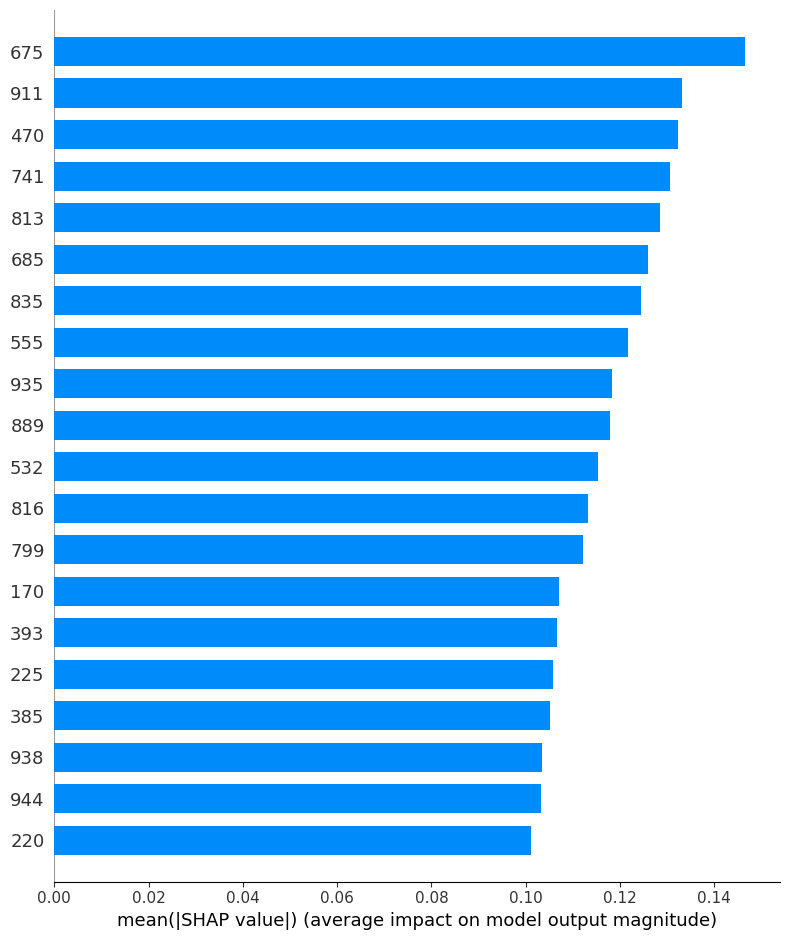

F1: 99.3


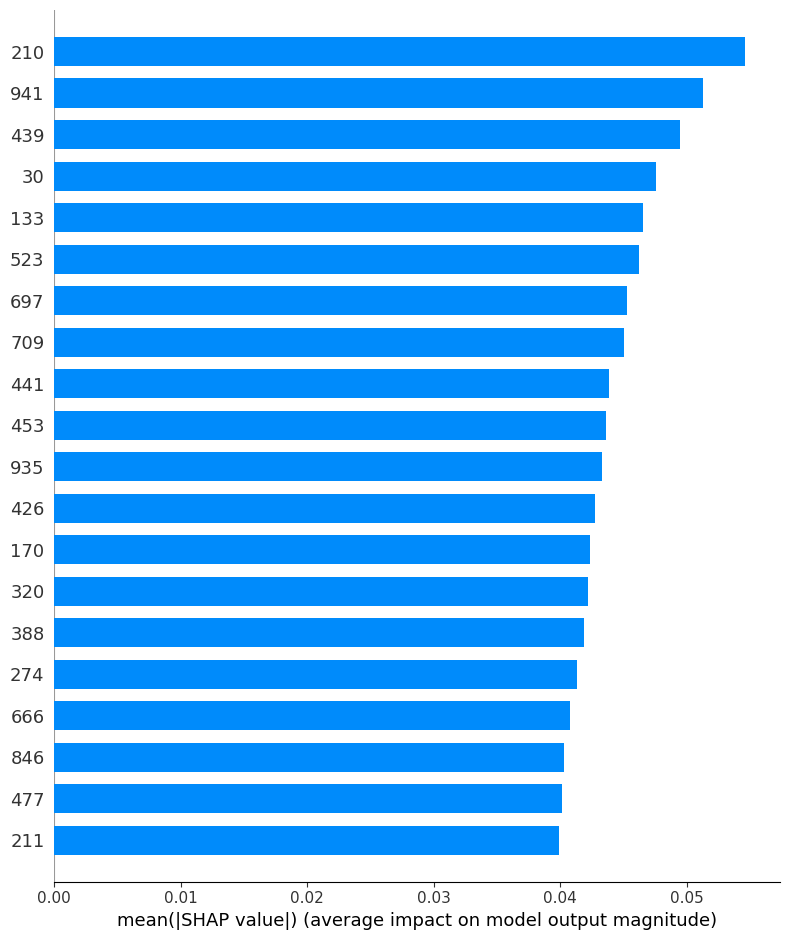

F1: 0.0


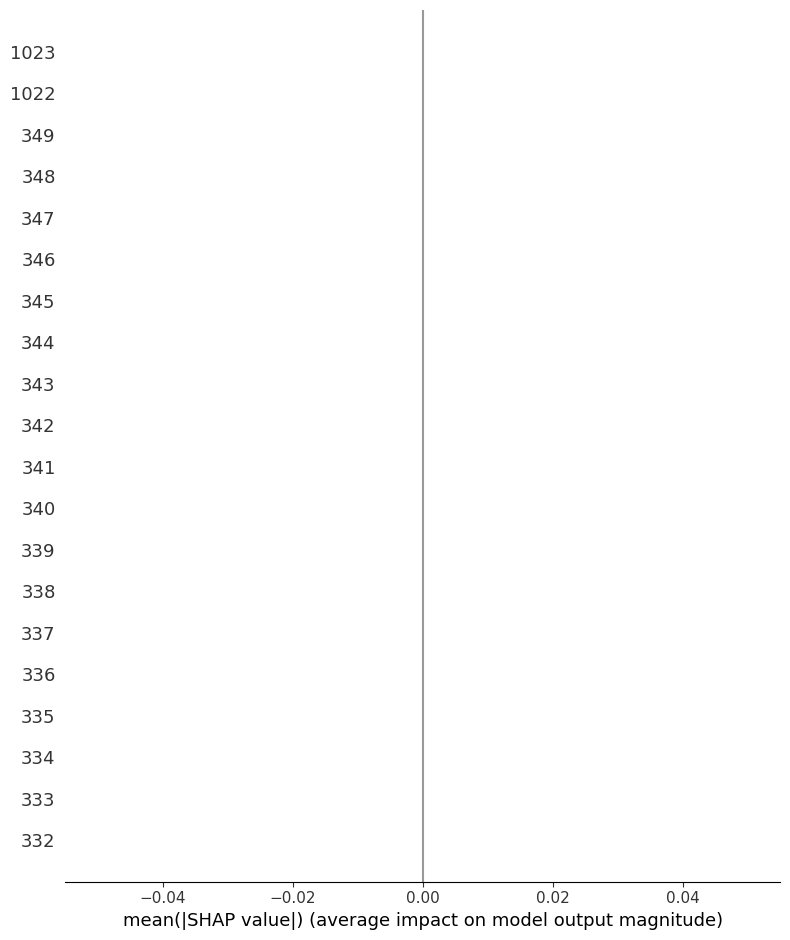

F1: 91.8


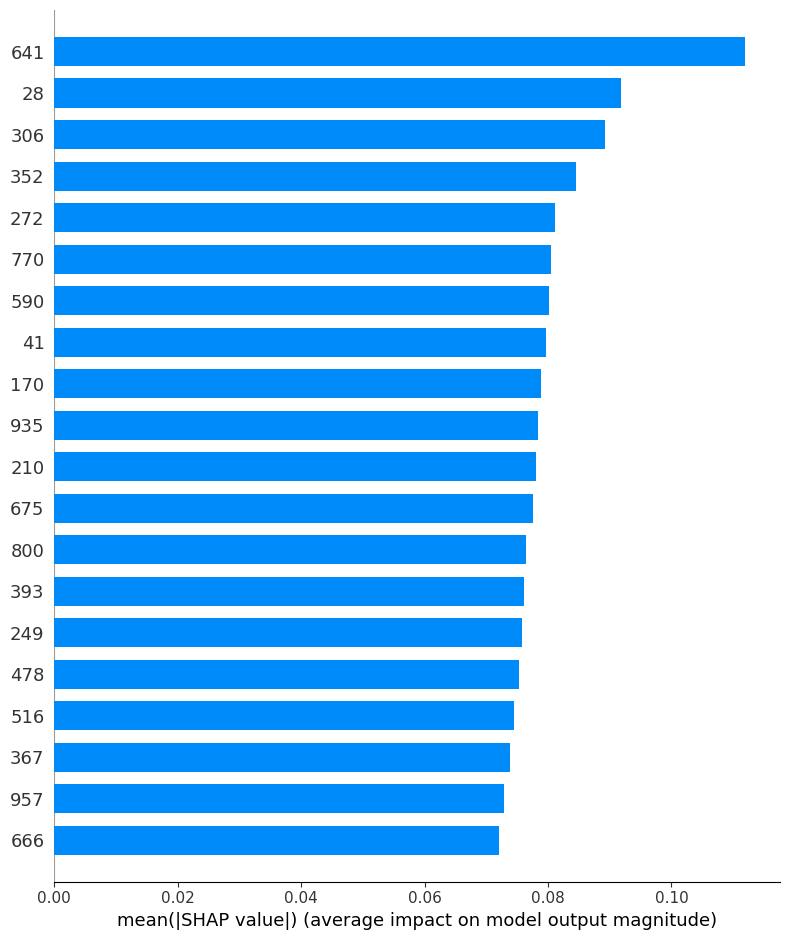

F1: 87.2


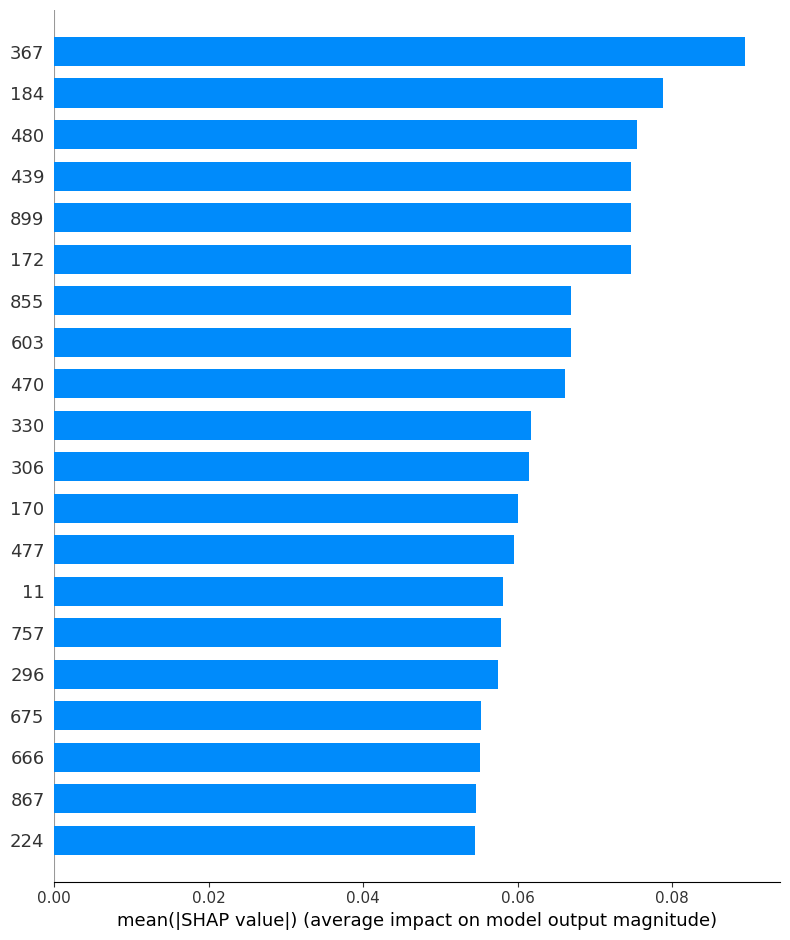

F1: 98.7


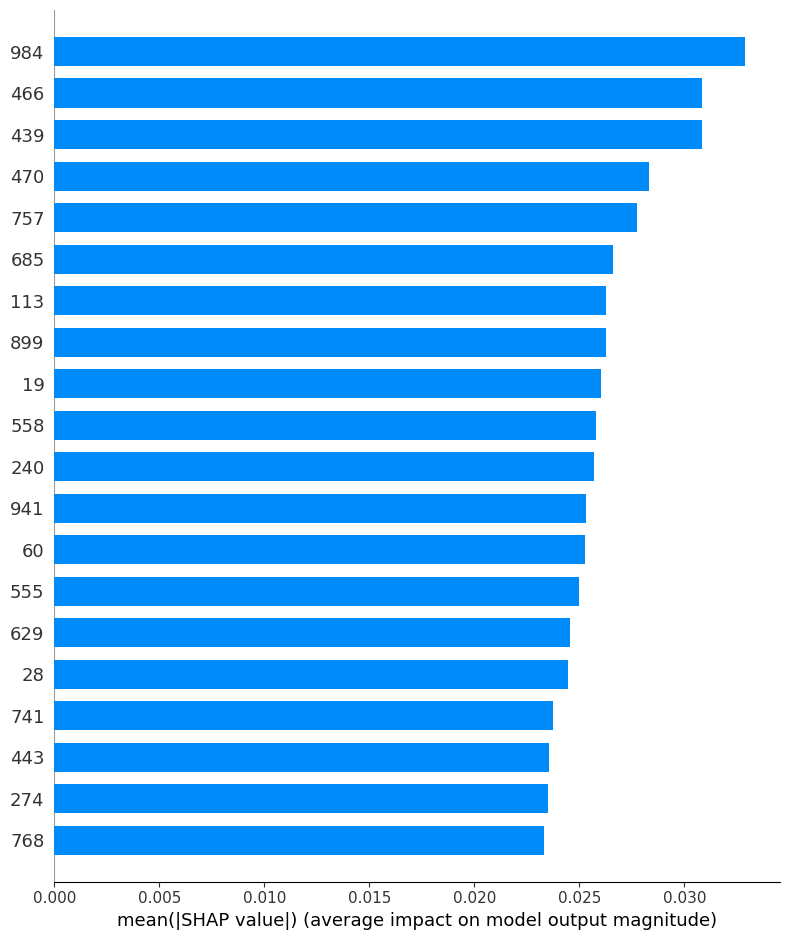

In [ ]:
wavlm_feature_names = [i for i in range(1024)]
wavlm_fi_dict = {}
emotions = ['anger', 'fear', 'neutrality', 'joy', 'sadness', 'disgust']

for e in emotions:

  wavlm_embeddings, wavlm_labels, wavlm_speakers = wavlm_embeddings_all[e], labels_all[e], speakers_all[e]

  trained_model, result = classification_pipeline(embeddings=wavlm_embeddings, speakers=wavlm_speakers, labels_list=wavlm_labels, feature_names=wavlm_feature_names)
  Performance['WavLM_all'][e] = result

  fi = feature_importance_method(X=wavlm_embeddings, y=wavlm_labels, feature_names=wavlm_feature_names, trained_model=trained_model)
  wavlm_fi_dict[e] = [tup[0] for tup in fi]


In [ ]:
num_wavlm_features = {e: 1 for e in emotions}

def plot_top_performance(e, importance_dict):
  wavlm_embeddings, wavlm_labels, wavlm_speakers = wavlm_embeddings_all[e], labels_all[e], speakers_all[e]
  top_scores = []
  bottom_scores = []
  rest_scores = []

  total = 1024

  for n in range(10, int(total/2), 10):

    top_features = importance_dict[e][:n]
    best_model, top_f1 = classification_pipeline(embeddings=wavlm_embeddings[:, top_features], speakers=wavlm_speakers, labels_list=wavlm_labels, feature_names=wavlm_feature_names)
    top_scores.append(top_f1)

    rest_features = importance_dict[e][n+1:]
    best_model, rest_f1 = classification_pipeline(embeddings=wavlm_embeddings[:, rest_features], speakers=wavlm_speakers, labels_list=wavlm_labels, feature_names=wavlm_feature_names)
    rest_scores.append(rest_f1)

    bottom_features = importance_dict[e][total-n-1:]
    best_model, bottom_f1 = classification_pipeline(embeddings=wavlm_embeddings[:, bottom_features], speakers=wavlm_speakers, labels_list=wavlm_labels, feature_names=wavlm_feature_names)
    bottom_scores.append(bottom_f1)

  n_features = range(10, int(total/2), 10)
  fig, ax = plt.subplots(figsize=(12, 6))

  ax.plot(n_features, top_scores, label='Top dimensions')
  ax.plot(n_features, rest_scores, label='Rest dimensions')
  ax.plot(n_features, bottom_scores, label='Bottom dimensions')

  ax.set_xlabel('Number of dimensions')
  ax.set_ylabel('F1 score')
  ax.set_title(e)
  ax.legend()

  percentile = np.percentile(top_scores, 100)
  # ax.axhline(y=percentile, color='r')

  ax.set_ylim(20, 105)
  x_val = find_x_at_n_percentile(n_features, top_scores, 100)
  ax.scatter(x_val, percentile, marker='x', color='red')

  return x_val, percentile



## Plot top performance

{'anger': [675, 911, 470, 741, 813, 685, 835, 555, 935, 889, 532, 816, 799, 170, 393, 225, 385, 938, 944, 220, 953, 796, 660, 321, 880, 166, 439, 268, 171, 30, 147, 263, 416, 644, 469, 523, 245, 344, 475, 709, 120, 130, 1003, 210, 687, 1018, 761, 267, 135, 310, 937, 989, 189, 668, 553, 240, 98, 590, 476, 819, 789, 495, 88, 413, 265, 249, 397, 294, 636, 559, 490, 607, 417, 750, 282, 233, 931, 699, 457, 562, 211, 618, 814, 208, 648, 492, 983, 564, 443, 70, 603, 39, 666, 589, 839, 658, 768, 464, 508, 759, 919, 679, 51, 778, 619, 290, 337, 89, 317, 794, 779, 349, 100, 92, 1021, 838, 404, 513, 17, 657, 560, 352, 306, 629, 990, 649, 635, 631, 504, 346, 224, 237, 683, 783, 690, 309, 373, 157, 984, 485, 861, 193, 367, 38, 980, 526, 327, 646, 455, 482, 46, 811, 79, 752, 133, 226, 753, 785, 430, 755, 645, 150, 348, 145, 647, 82, 804, 95, 258, 1007, 890, 328, 408, 124, 275, 392, 851, 1, 400, 958, 991, 435, 805, 924, 144, 899, 573, 873, 315, 710, 593, 708, 654, 9, 865, 613, 320, 105, 550, 758, 62,

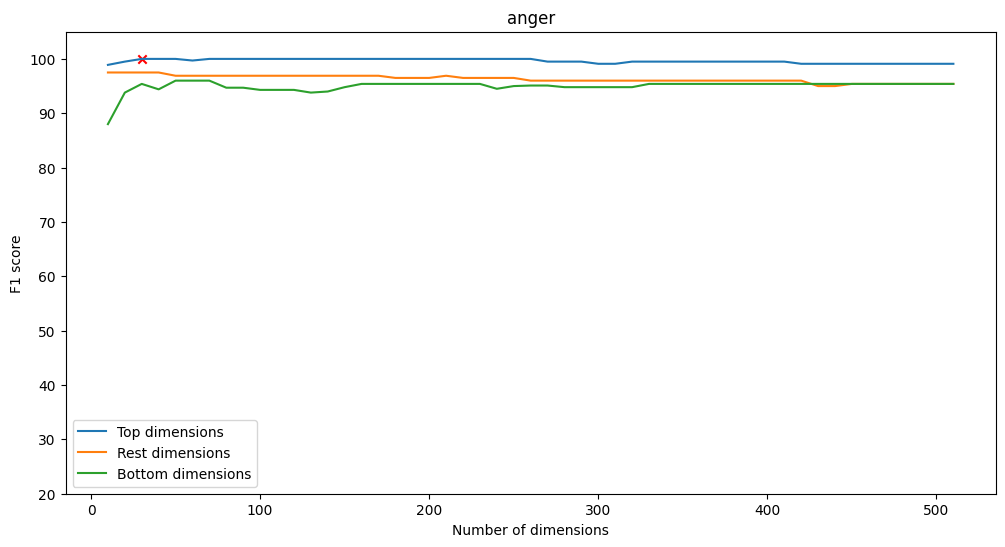

In [ ]:
emotions = ['anger', 'fear', 'neutrality', 'joy', 'sadness', 'disgust']
print(wavlm_fi_dict)
num_wavlm_features[emotions[0]], Performance['WavLM_top_features'][emotions[0]] = plot_top_performance(emotions[0], wavlm_fi_dict)


F1: 98.3
F1: 99.3
F1: 81.0
F1: 97.8
F1: 98.2
F1: 81.7
F1: 97.8
F1: 98.2
F1: 86.5
F1: 98.4
F1: 98.2
F1: 86.2
F1: 97.8
F1: 97.8
F1: 86.7
F1: 98.4
F1: 98.2
F1: 86.3
F1: 98.9
F1: 97.7
F1: 84.6
F1: 99.5
F1: 97.3
F1: 87.1
F1: 98.9
F1: 96.7
F1: 87.6
F1: 98.9
F1: 97.8
F1: 89.4
F1: 100.0
F1: 97.2
F1: 89.1
F1: 100.0
F1: 96.7
F1: 89.8
F1: 100.0
F1: 97.8
F1: 90.3
F1: 100.0
F1: 97.8
F1: 90.9
F1: 100.0
F1: 97.3
F1: 90.4
F1: 100.0
F1: 97.3
F1: 88.8
F1: 99.5
F1: 96.3
F1: 88.8
F1: 99.5
F1: 96.3
F1: 89.0
F1: 98.9
F1: 96.3
F1: 89.6
F1: 98.9
F1: 96.3
F1: 90.0
F1: 98.9
F1: 97.3
F1: 90.2
F1: 98.9
F1: 96.8
F1: 90.4
F1: 98.9
F1: 96.8
F1: 92.1
F1: 98.9
F1: 97.3
F1: 92.1
F1: 98.3
F1: 95.7
F1: 91.6
F1: 98.9
F1: 96.3
F1: 91.3
F1: 98.9
F1: 96.8
F1: 89.6
F1: 98.9
F1: 96.8
F1: 89.6
F1: 98.9
F1: 96.8
F1: 91.3
F1: 98.9
F1: 96.8
F1: 90.7
F1: 98.9
F1: 96.8
F1: 91.1
F1: 99.4
F1: 96.2
F1: 91.6
F1: 99.4
F1: 95.7
F1: 91.6
F1: 99.4
F1: 95.7
F1: 91.6
F1: 99.4
F1: 95.2
F1: 91.6
F1: 99.4
F1: 95.2
F1: 92.6
F1: 99.4
F1: 95.2
F1: 

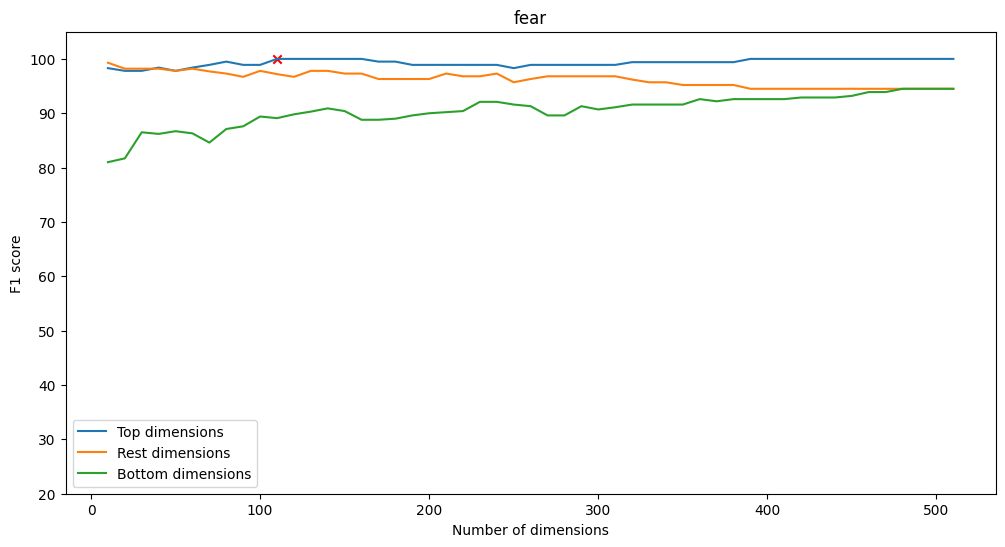

In [ ]:

num_wavlm_features[emotions[1]], Performance['WavLM_top_features'][emotions[1]]  = plot_top_performance(emotions[1], wavlm_fi_dict)


F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0


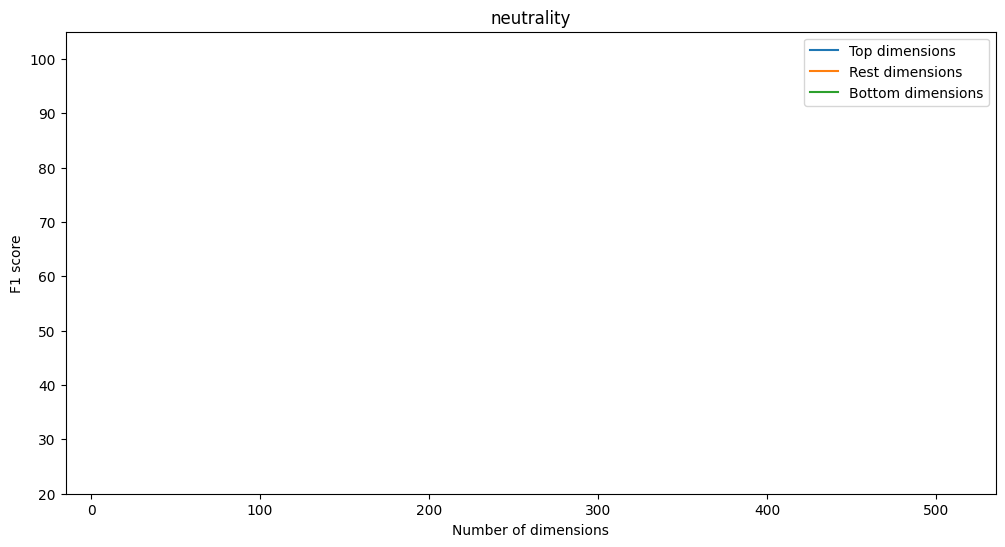

In [ ]:

num_wavlm_features[emotions[2]], Performance['WavLM_top_features'][emotions[2]] = plot_top_performance(emotions[2], wavlm_fi_dict)


F1: 94.5
F1: 90.3
F1: 76.1
F1: 95.4
F1: 89.9
F1: 81.4
F1: 96.8
F1: 90.4
F1: 79.2
F1: 97.2
F1: 91.3
F1: 79.8
F1: 97.1
F1: 90.4
F1: 79.9
F1: 98.9
F1: 91.0
F1: 77.6
F1: 97.1
F1: 91.3
F1: 76.5
F1: 97.0
F1: 89.3
F1: 77.9
F1: 97.1
F1: 89.2
F1: 77.4
F1: 96.4
F1: 87.4
F1: 77.8
F1: 98.3
F1: 88.0
F1: 79.9
F1: 98.3
F1: 88.0
F1: 78.7
F1: 98.3
F1: 88.9
F1: 80.5
F1: 98.3
F1: 87.2
F1: 80.1
F1: 97.7
F1: 87.2
F1: 79.2
F1: 99.4
F1: 87.7
F1: 79.7
F1: 99.4
F1: 87.2
F1: 80.1
F1: 99.4
F1: 86.9
F1: 81.5
F1: 98.8
F1: 86.9
F1: 81.5
F1: 99.4
F1: 86.9
F1: 81.1
F1: 98.9
F1: 86.6
F1: 81.6
F1: 98.9
F1: 86.2
F1: 81.6
F1: 98.8
F1: 85.9
F1: 81.6
F1: 98.3
F1: 85.9
F1: 81.0
F1: 98.3
F1: 86.4
F1: 81.0
F1: 98.3
F1: 85.1
F1: 80.4
F1: 98.3
F1: 84.7
F1: 80.0
F1: 98.3
F1: 85.1
F1: 79.7
F1: 98.8
F1: 84.5
F1: 79.7
F1: 98.3
F1: 85.1
F1: 79.7
F1: 98.3
F1: 85.1
F1: 79.7
F1: 98.8
F1: 84.9
F1: 78.9
F1: 98.8
F1: 83.6
F1: 79.9
F1: 98.8
F1: 84.5
F1: 80.9
F1: 98.8
F1: 84.5
F1: 80.2
F1: 98.8
F1: 84.2
F1: 80.2
F1: 97.7
F1: 84.9
F1: 80.8
F

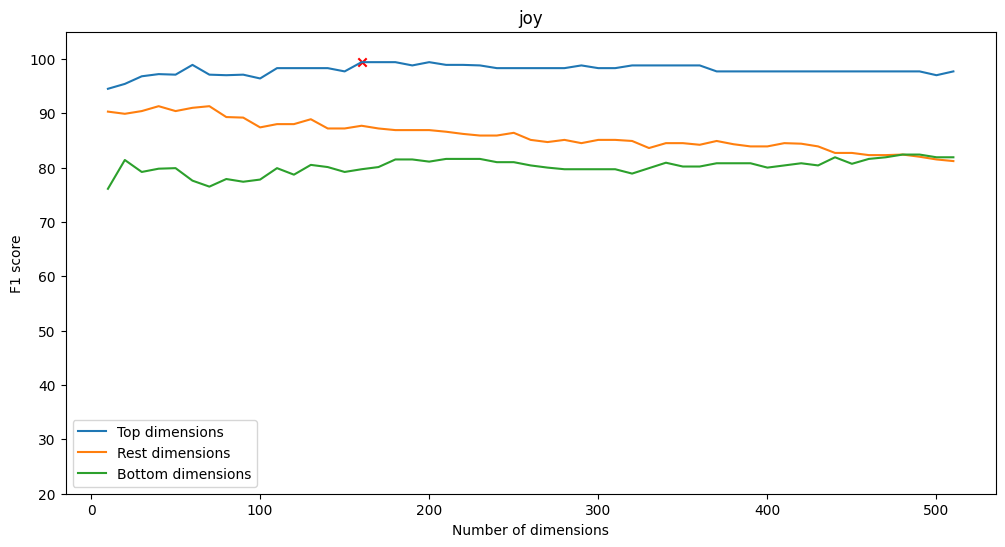

In [ ]:

num_wavlm_features[emotions[3]], Performance['WavLM_top_features'][emotions[3]] = plot_top_performance(emotions[3], wavlm_fi_dict)


F1: 94.3
F1: 85.0
F1: 63.9
F1: 94.0
F1: 85.0
F1: 64.9
F1: 95.6
F1: 85.8
F1: 64.6
F1: 95.0
F1: 84.8
F1: 64.4
F1: 96.1
F1: 84.4
F1: 68.5
F1: 96.4
F1: 82.7
F1: 67.2
F1: 96.4
F1: 81.7
F1: 69.0
F1: 95.9
F1: 81.4
F1: 69.4
F1: 95.2
F1: 81.0
F1: 69.8
F1: 96.4
F1: 80.7
F1: 69.2
F1: 96.4
F1: 80.9
F1: 70.3
F1: 96.4
F1: 80.5
F1: 69.3
F1: 95.2
F1: 80.5
F1: 66.5
F1: 95.9
F1: 81.7
F1: 69.8
F1: 94.6
F1: 80.4
F1: 66.7
F1: 95.9
F1: 79.8
F1: 66.4
F1: 96.5
F1: 80.2
F1: 65.5
F1: 95.9
F1: 79.4
F1: 64.2
F1: 95.9
F1: 79.1
F1: 64.8
F1: 95.9
F1: 78.7
F1: 66.6
F1: 96.0
F1: 77.5
F1: 64.7
F1: 96.0
F1: 75.8
F1: 63.1
F1: 95.3
F1: 75.5
F1: 64.6
F1: 95.5
F1: 74.6
F1: 64.7
F1: 96.0
F1: 75.1
F1: 63.7
F1: 96.0
F1: 75.1
F1: 63.7
F1: 96.6
F1: 74.8
F1: 64.4
F1: 95.4
F1: 74.8
F1: 65.3
F1: 95.4
F1: 76.1
F1: 64.9
F1: 95.4
F1: 74.8
F1: 67.3
F1: 95.4
F1: 73.9
F1: 65.8
F1: 95.0
F1: 73.6
F1: 67.3
F1: 95.4
F1: 74.0
F1: 67.1
F1: 95.4
F1: 73.6
F1: 68.4
F1: 95.9
F1: 72.7
F1: 68.4
F1: 95.9
F1: 72.1
F1: 68.3
F1: 95.3
F1: 71.3
F1: 68.9
F

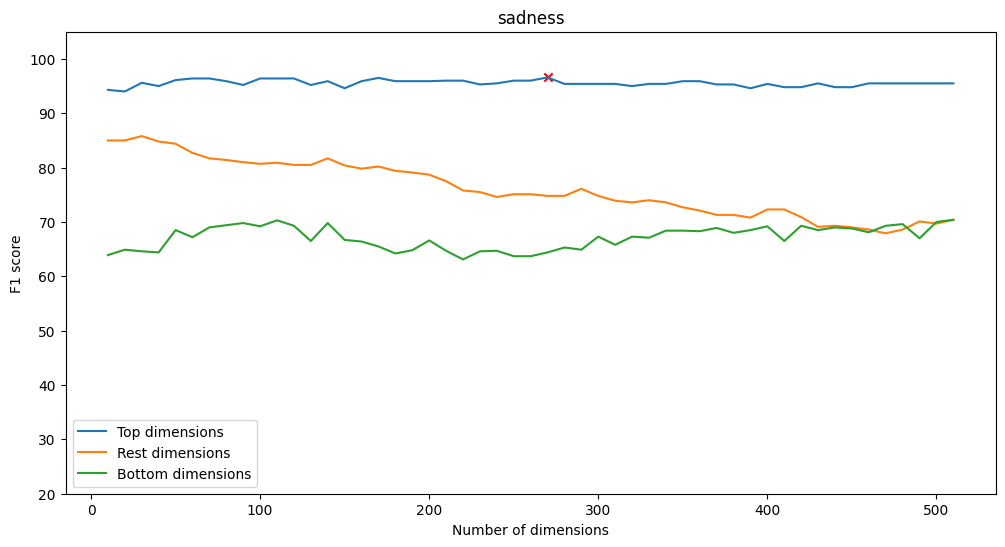

In [ ]:

num_wavlm_features[emotions[4]], Performance['WavLM_top_features'][emotions[4]] = plot_top_performance(emotions[4], wavlm_fi_dict)


F1: 99.1
F1: 98.7
F1: 74.6
F1: 99.7
F1: 98.7
F1: 74.5
F1: 99.7
F1: 98.7
F1: 74.3
F1: 99.7
F1: 98.7
F1: 82.8
F1: 100.0
F1: 98.7
F1: 79.9
F1: 100.0
F1: 98.7
F1: 82.7
F1: 100.0
F1: 98.7
F1: 83.1
F1: 100.0
F1: 98.7
F1: 81.0
F1: 100.0
F1: 98.7
F1: 82.7
F1: 100.0
F1: 98.7
F1: 82.4
F1: 100.0
F1: 98.7
F1: 84.6
F1: 100.0
F1: 98.7
F1: 84.4
F1: 100.0
F1: 98.7
F1: 88.6
F1: 100.0
F1: 98.7
F1: 87.5
F1: 100.0
F1: 98.7
F1: 88.2
F1: 100.0
F1: 98.7
F1: 89.2
F1: 100.0
F1: 98.7
F1: 88.2
F1: 100.0
F1: 98.7
F1: 87.3
F1: 100.0
F1: 98.7
F1: 89.2
F1: 99.7
F1: 98.7
F1: 89.7
F1: 99.7
F1: 98.7
F1: 89.5
F1: 99.7
F1: 98.7
F1: 90.5
F1: 100.0
F1: 98.7
F1: 91.5
F1: 100.0
F1: 98.7
F1: 91.2
F1: 100.0
F1: 98.7
F1: 91.8
F1: 100.0
F1: 98.7
F1: 91.0
F1: 100.0
F1: 98.7
F1: 90.1
F1: 100.0
F1: 98.7
F1: 91.0
F1: 100.0
F1: 98.7
F1: 92.2
F1: 100.0
F1: 98.7
F1: 91.4
F1: 100.0
F1: 98.1
F1: 92.0
F1: 100.0
F1: 98.1
F1: 92.0
F1: 100.0
F1: 98.1
F1: 90.9
F1: 100.0
F1: 98.7
F1: 91.5
F1: 100.0
F1: 98.1
F1: 91.2
F1: 100.0
F1: 98.1
F1: 91.3

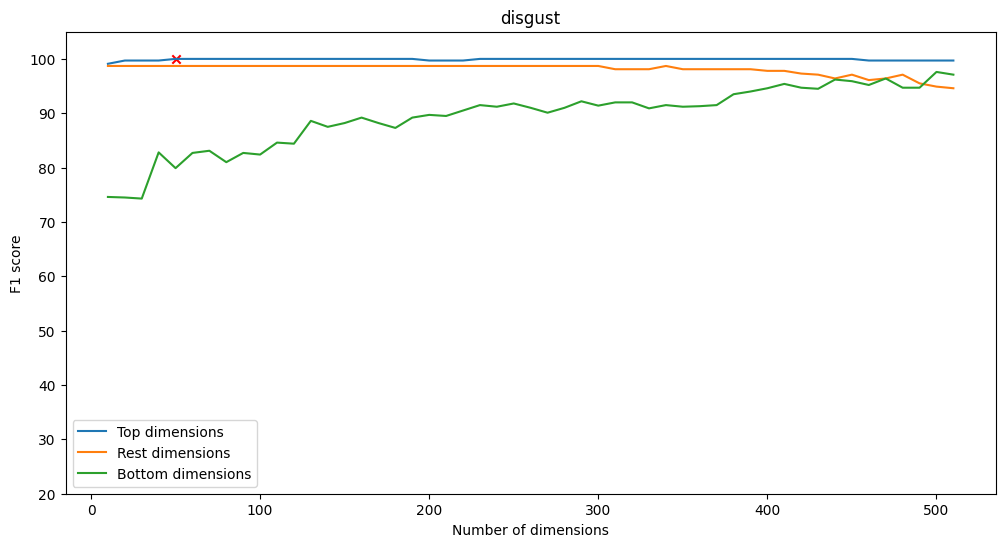

In [ ]:

num_wavlm_features[emotions[5]], Performance['WavLM_top_features'][emotions[5]] = plot_top_performance(emotions[5], wavlm_fi_dict)


In [ ]:
print(num_wavlm_features)


{'anger': 30, 'fear': 110, 'neutrality': 10, 'joy': 160, 'sadness': 270, 'disgust': 50}


# Regression + Metrics Code
Code for the regression task and evaluating metrics based on RMSE top and RMSE all for every eGeMAPS feature for each emotion

In [ ]:
def weighted_difference_rmse(RMSE_all, RMSE_top):
  # Performance change: this metric effectively captures both the magnitude and direction of change. The numerator emphasizes proportional change, while the denominator adjusts for the scale of RMSE values, ensuring that the metric is sensitive to relative improvement or degradation.
  # Weighting: based on the average RMSE, which balances the influence of both before and after performance. This approach somewhat weights the performance, favoring models with overall lower RMSE values. However, it might not strongly emphasize absolute performance post-change as the average RMSE dilutes this effect.
    change_ratio = (RMSE_top - RMSE_all) / RMSE_all
    average_rmse = (RMSE_all + RMSE_top) / 2
    return change_ratio * (1 / average_rmse)

def harmonic_mean_metric(RMSE_all, RMSE_top):
  # Performance change: This metric combines improvement rate and performance rate in a balanced manner, ensuring that both aspects are equally important. It's particularly sensitive to scenarios where both improvement and post-change performance are strong but doesn't favor one excessively over the other.
  # Weighting: The harmonic mean inherently gives equal weight to improvement and post-change performance. This method ensures that a high score requires both significant improvement and strong performance, making it a balanced choice between change and performance weighting.
    improvement_rate = RMSE_all / RMSE_top
    performance_rate = 1 / RMSE_top
    return 2 / ((1 / improvement_rate) + (1 / performance_rate))

def change_index_adjusted_performance(RMSE_all, RMSE_top):
  # Performance change: This metric clearly reflects proportional change. The exponential factor introduces a strong performance weighting, emphasizing the importance of lower RMSE values after the change.
  # Weighting: The exponential decay heavily weights the performance aspect, significantly favoring lower (better) RMSE values after the change. It's highly sensitive to post-change performance, potentially at the expense of recognizing substantial proportional improvements from a high baseline.
    change_ratio = RMSE_top / RMSE_all
    performance_factor = np.exp(-RMSE_top)
    return change_ratio * performance_factor

def performance_weighted_change_score(RMSE_all, RMSE_top):
  # Performance change: This formula directly quantifies the improvement in RMSE and scales it by the inverse of the post-change RMSE, making it sensitive to both the direction and scale of change
  # Weighting: By inversely scaling by RMSEafter, this metric places a significant emphasis on post-change performance. The better the performance (i.e., the lower the RMSE after), the higher the metric value, making it strongly performance-weighted.
    return (RMSE_all - RMSE_top) * (1 / RMSE_top)

In [ ]:
predicted_df_dict = {}

import numpy as np
from tqdm import tqdm

def top_wavlm_predict_ege(e):
    rmse_top_list = []
    rmse_all_list = []
    rmse_top_all = []
    rmse_top_squared_all = []
    weighted_difference_rmse_all = []
    harmonic_mean_metric_all = []
    change_index_adjusted_performance_all = []
    performance_weighted_change_score_all = []

    wavlm_embeddings, wavlm_labels, wavlm_speakers = wavlm_embeddings_all[e], labels_all[e], speakers_all[e]
    ege_embeddings, ege_labels, ege_speakers = egemaps_embeddings_all[e], labels_all[e], speakers_all[e]

    top_features = wavlm_fi_dict[e][:num_wavlm_features[e]]
    all_features = wavlm_fi_dict[e][:]

    for i in tqdm(range(88)):
        rmse_top = prediction_pipeline(wavlm_embeddings[:, top_features], ege_embeddings[:,i], regression_model='ridge')
        rmse_all = prediction_pipeline(wavlm_embeddings[:, all_features], ege_embeddings[:,i], regression_model='ridge')
        rmse_top_list.append(np.round(rmse_top, 3))
        rmse_all_list.append(np.round(rmse_all, 3))
        rmse_top_all.append(np.round(rmse_top/rmse_all, 3))
        rmse_top_squared_all.append(np.round(rmse_top**2/rmse_all, 3))

        # Calculate additional metrics
        weighted_difference_rmse_all.append(np.round(weighted_difference_rmse(rmse_all, rmse_top), 3))
        harmonic_mean_metric_all.append(np.round(harmonic_mean_metric(rmse_all, rmse_top), 3))
        change_index_adjusted_performance_all.append(np.round(change_index_adjusted_performance(rmse_all, rmse_top), 3))
        performance_weighted_change_score_all.append(np.round(performance_weighted_change_score(rmse_all, rmse_top), 3))

    prediction_metrics_dict = {
        'Feature': egemaps_feature_names,
        'rmse_top_all': rmse_top_all,
        'rmse_top_squared_all': rmse_top_squared_all,
        'rmse_top': rmse_top_list,
        'rmse_all': rmse_all_list,
        'weighted_difference_rmse_all': weighted_difference_rmse_all,
        'harmonic_mean_metric_all': harmonic_mean_metric_all,
        'change_index_adjusted_performance_all': change_index_adjusted_performance_all,
        'performance_weighted_change_score_all': performance_weighted_change_score_all
    }
    return prediction_metrics_dict




# Regression + Metrics Results
Metrics for Each EgeMAPS Feature For All Emotions

## Anger

In [ ]:
df = pd.DataFrame(top_wavlm_predict_ege(emotions[0]))
sorted_df = df.sort_values(by='rmse_top_all', ascending=True)
predicted_df_dict[emotions[0]] = sorted_df


100%|██████████| 88/88 [00:01<00:00, 49.85it/s]


In [ ]:
sorted_df.head(30)

,Feature,rmse_top_all,rmse_top_squared_all,rmse_top,rmse_all,weighted_difference_rmse_all,harmonic_mean_metric_all,change_index_adjusted_performance_all,performance_weighted_change_score_all
37,logRelF0-H1-H2_sma3nz_stddevNorm,0.564,0.489,0.867,1.539,-0.363,1.398,0.237,0.774
73,mfcc3V_sma3nz_stddevNorm,0.594,0.356,0.599,1.008,-0.505,1.675,0.326,0.682
29,mfcc4_sma3_stddevNorm,0.640,0.457,0.713,1.114,-0.394,1.478,0.314,0.562
49,F2bandwidth_sma3nz_stddevNorm,0.645,0.579,0.898,1.392,-0.310,1.297,0.263,0.551
71,mfcc2V_sma3nz_stddevNorm,0.724,0.746,1.030,1.423,-0.225,1.140,0.258,0.381
33,shimmerLocaldB_sma3nz_stddevNorm,0.745,0.626,0.840,1.127,-0.259,1.262,0.322,0.341
75,mfcc4V_sma3nz_stddevNorm,0.821,0.606,0.739,0.900,-0.219,1.282,0.392,0.218
42,F1bandwidth_sma3nz_amean,0.834,0.647,0.776,0.931,-0.195,1.242,0.384,0.199
25,mfcc2_sma3_stddevNorm,0.838,0.784,0.935,1.116,-0.158,1.128,0.329,0.193
54,F3bandwidth_sma3nz_amean,0.848,0.840,0.991,1.169,-0.141,1.088,0.315,0.179


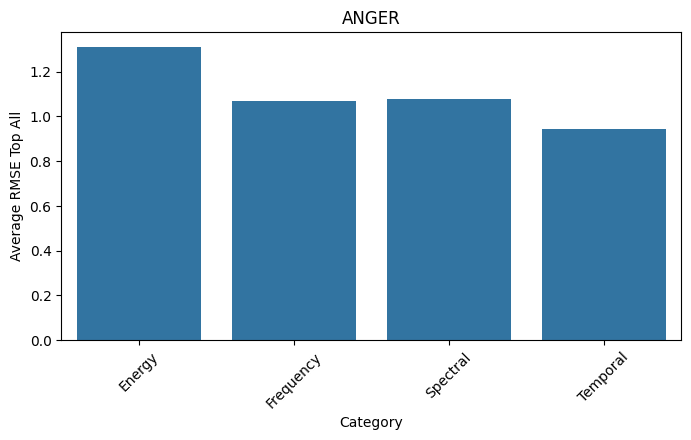

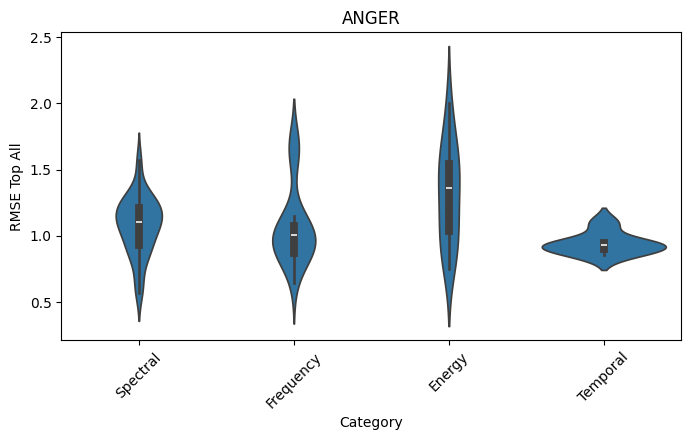

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the dictionary and sorted_df are already defined
# Define the dictionary
egemaps_category_dict = {
    'F0semitoneFrom27.5Hz_sma3nz_amean': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_stddevNorm': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_percentile20.0': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_percentile50.0': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_percentile80.0': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope': 'Frequency',
    'jitterLocal_sma3nz_amean': 'Frequency',
    'jitterLocal_sma3nz_stddevNorm': 'Frequency',
    'shimmerLocaldB_sma3nz_amean': 'Energy',
    'shimmerLocaldB_sma3nz_stddevNorm': 'Energy',
    'loudness_sma3_amean': 'Energy',
    'loudness_sma3_stddevNorm': 'Energy',
    'loudness_sma3_percentile20.0': 'Energy',
    'loudness_sma3_percentile50.0': 'Energy',
    'loudness_sma3_percentile80.0': 'Energy',
    'loudness_sma3_pctlrange0-2': 'Energy',
    'loudness_sma3_meanRisingSlope': 'Energy',
    'loudness_sma3_stddevRisingSlope': 'Energy',
    'loudness_sma3_meanFallingSlope': 'Energy',
    'loudness_sma3_stddevFallingSlope': 'Energy',
    'HNRdBACF_sma3nz_amean': 'Energy',
    'HNRdBACF_sma3nz_stddevNorm': 'Energy',
    'spectralFlux_sma3_amean': 'Spectral',
    'spectralFlux_sma3_stddevNorm': 'Spectral',
    'mfcc1_sma3_amean': 'Spectral',
    'mfcc1_sma3_stddevNorm': 'Spectral',
    'mfcc2_sma3_amean': 'Spectral',
    'mfcc2_sma3_stddevNorm': 'Spectral',
    'mfcc3_sma3_amean': 'Spectral',
    'mfcc3_sma3_stddevNorm': 'Spectral',
    'mfcc4_sma3_amean': 'Spectral',
    'mfcc4_sma3_stddevNorm': 'Spectral',
    'logRelF0-H1-H2_sma3nz_amean': 'Spectral',
    'logRelF0-H1-H2_sma3nz_stddevNorm': 'Spectral',
    'logRelF0-H1-A3_sma3nz_amean': 'Spectral',
    'logRelF0-H1-A3_sma3nz_stddevNorm': 'Spectral',
    'F1frequency_sma3nz_amean': 'Frequency',
    'F1frequency_sma3nz_stddevNorm': 'Frequency',
    'F1bandwidth_sma3nz_amean': 'Frequency',
    'F1bandwidth_sma3nz_stddevNorm': 'Frequency',
    'F1amplitudeLogRelF0_sma3nz_amean': 'Spectral',
    'F1amplitudeLogRelF0_sma3nz_stddevNorm': 'Spectral',
    'F2frequency_sma3nz_amean': 'Frequency',
    'F2frequency_sma3nz_stddevNorm': 'Frequency',
    'F2bandwidth_sma3nz_amean': 'Frequency',
    'F2bandwidth_sma3nz_stddevNorm': 'Frequency',
    'F2amplitudeLogRelF0_sma3nz_amean': 'Spectral',
    'F2amplitudeLogRelF0_sma3nz_stddevNorm': 'Spectral',
    'F3frequency_sma3nz_amean': 'Frequency',
    'F3frequency_sma3nz_stddevNorm': 'Frequency',
    'F3bandwidth_sma3nz_amean': 'Frequency',
    'F3bandwidth_sma3nz_stddevNorm': 'Frequency',
    'F3amplitudeLogRelF0_sma3nz_amean': 'Spectral',
    'F3amplitudeLogRelF0_sma3nz_stddevNorm': 'Spectral',
    'alphaRatioV_sma3nz_amean': 'Spectral',
    'alphaRatioV_sma3nz_stddevNorm': 'Spectral',
    'hammarbergIndexV_sma3nz_amean': 'Spectral',
    'hammarbergIndexV_sma3nz_stddevNorm': 'Spectral',
    'slopeV0-500_sma3nz_amean': 'Spectral',
    'slopeV0-500_sma3nz_stddevNorm': 'Spectral',
    'slopeV500-1500_sma3nz_amean': 'Spectral',
    'slopeV500-1500_sma3nz_stddevNorm': 'Spectral',
    'spectralFluxV_sma3nz_amean': 'Spectral',
    'spectralFluxV_sma3nz_stddevNorm': 'Spectral',
    'mfcc1V_sma3nz_amean': 'Spectral',
    'mfcc1V_sma3nz_stddevNorm': 'Spectral',
    'mfcc2V_sma3nz_amean': 'Spectral',
    'mfcc2V_sma3nz_stddevNorm': 'Spectral',
    'mfcc3V_sma3nz_amean': 'Spectral',
    'mfcc3V_sma3nz_stddevNorm': 'Spectral',
    'mfcc4V_sma3nz_amean': 'Spectral',
    'mfcc4V_sma3nz_stddevNorm': 'Spectral',
    'alphaRatioUV_sma3nz_amean': 'Spectral',
    'hammarbergIndexUV_sma3nz_amean': 'Spectral',
    'slopeUV0-500_sma3nz_amean': 'Spectral',
    'slopeUV500-1500_sma3nz_amean': 'Spectral',
    'spectralFluxUV_sma3nz_amean': 'Spectral',
    'loudnessPeaksPerSec': 'Temporal',
    'VoicedSegmentsPerSec': 'Temporal',
    'MeanVoicedSegmentLengthSec': 'Temporal',
    'StddevVoicedSegmentLengthSec': 'Temporal',
    'MeanUnvoicedSegmentLength': 'Temporal',
    'StddevUnvoicedSegmentLength': 'Temporal',
    'equivalentSoundLevel_dBp': 'Energy',
}

# Add 'category' column
sorted_df['category'] = sorted_df['Feature'].map(egemaps_category_dict)

# Compute average rmse_top_all for each category
category_avg = sorted_df.groupby('category')['rmse_top_all'].mean().reset_index()

# Plot bar chart
plt.figure(figsize=(8, 4))
sns.barplot(x='category', y='rmse_top_all', data=category_avg)
plt.title('ANGER')
plt.xlabel('Category')
plt.ylabel('Average RMSE Top All')
plt.xticks(rotation=45)
plt.show()


# Plot violin plot
plt.figure(figsize=(8, 4))
sns.violinplot(x='category', y='rmse_top_all', data=sorted_df)
plt.title('ANGER')
plt.xlabel('Category')
plt.ylabel('RMSE Top All')
plt.xticks(rotation=45)
plt.show()



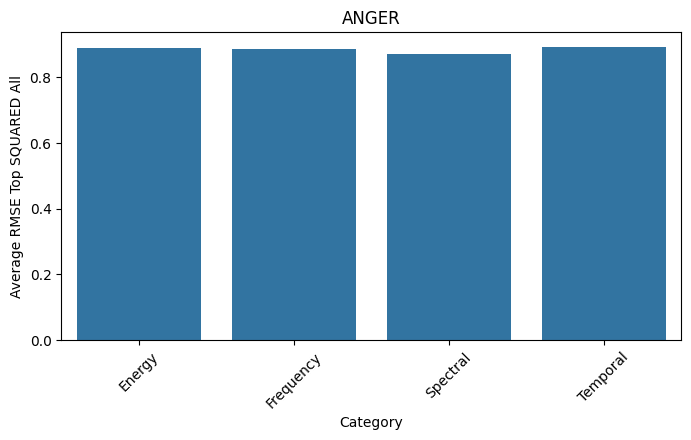

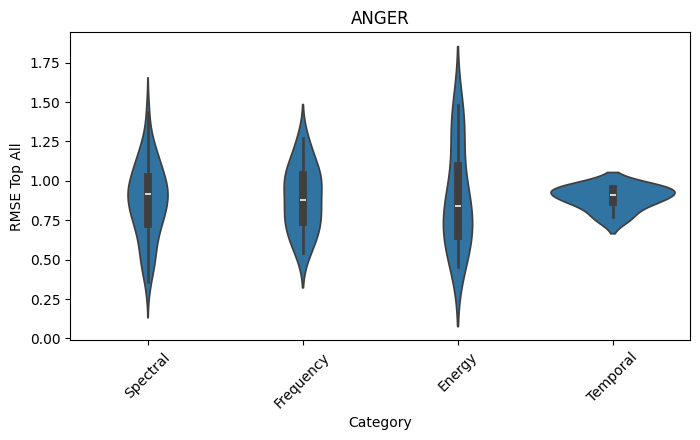

In [ ]:
# Compute average rmse_top_all for each category
category_avg = sorted_df.groupby('category')['rmse_top_squared_all'].mean().reset_index()
sorted_df.to_pickle('anger_ravdess_infogain.pkl')

# Plot bar chart
plt.figure(figsize=(8, 4))
sns.barplot(x='category', y='rmse_top_squared_all', data=category_avg)
plt.title('ANGER')
plt.xlabel('Category')
plt.ylabel('Average RMSE Top SQUARED All')
plt.xticks(rotation=45)
plt.show()

# Plot violin plot
plt.figure(figsize=(8, 4))
sns.violinplot(x='category', y='rmse_top_squared_all', data=sorted_df)
plt.title('ANGER')
plt.xlabel('Category')
plt.ylabel('RMSE Top All')
plt.xticks(rotation=45)
plt.show()


## Fear

In [ ]:
df = pd.DataFrame(top_wavlm_predict_ege(emotions[1]))
sorted_df = df.sort_values(by='rmse_top_squared_all', ascending=True)
predicted_df_dict[emotions[1]] = sorted_df


100%|██████████| 88/88 [00:01<00:00, 48.43it/s]


In [ ]:
sorted_df.head(10)

,Feature,rmse_top_all,rmse_top_squared_all,rmse_top,rmse_all,weighted_difference_rmse_all,harmonic_mean_metric_all,change_index_adjusted_performance_all,performance_weighted_change_score_all
2,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,1.151,0.534,0.464,0.403,0.348,1.238,0.723,-0.131
0,F0semitoneFrom27.5Hz_sma3nz_amean,1.246,0.539,0.432,0.347,0.632,1.192,0.809,-0.198
68,mfcc1V_sma3nz_amean,1.258,0.545,0.433,0.344,0.664,1.182,0.816,-0.205
3,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,1.283,0.555,0.433,0.337,0.736,1.166,0.833,-0.221
4,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,1.317,0.558,0.423,0.322,0.850,1.149,0.862,-0.240
87,equivalentSoundLevel_dBp,1.583,0.581,0.367,0.232,1.948,1.026,1.097,-0.368
14,loudness_sma3_percentile80.0,1.483,0.604,0.407,0.275,1.415,1.058,0.987,-0.326
15,loudness_sma3_pctlrange0-2,1.504,0.607,0.404,0.269,1.498,1.048,1.004,-0.335
58,alphaRatioV_sma3nz_amean,1.202,0.697,0.580,0.483,0.379,1.122,0.673,-0.168
75,mfcc4V_sma3nz_stddevNorm,0.882,0.701,0.794,0.901,-0.140,1.193,0.398,0.134


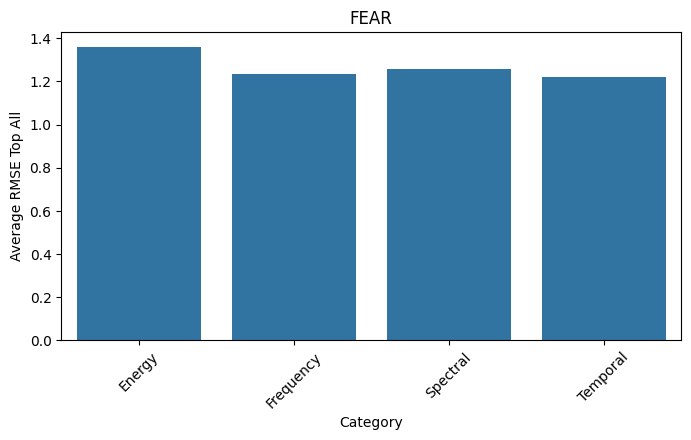

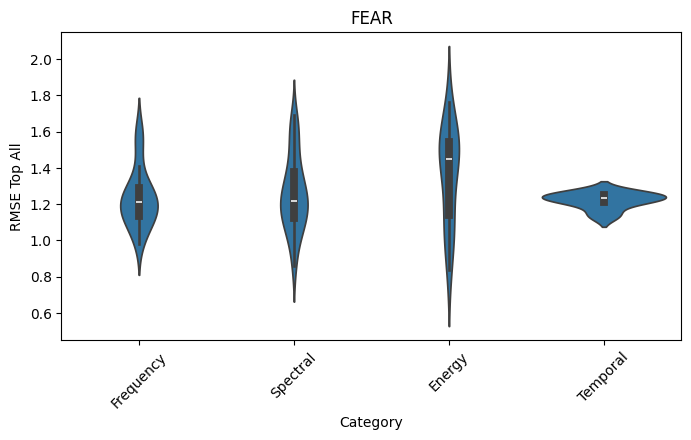

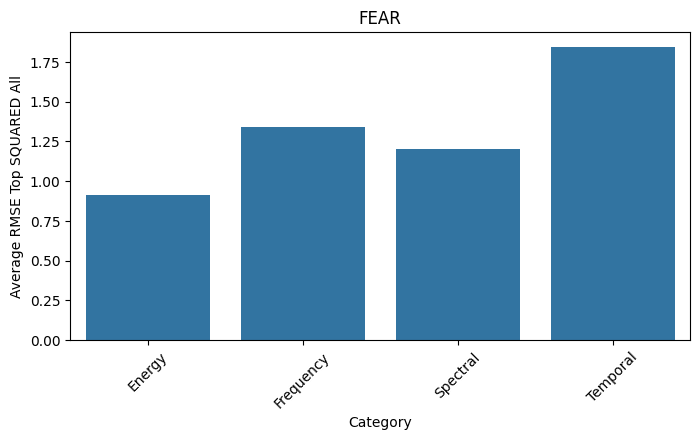

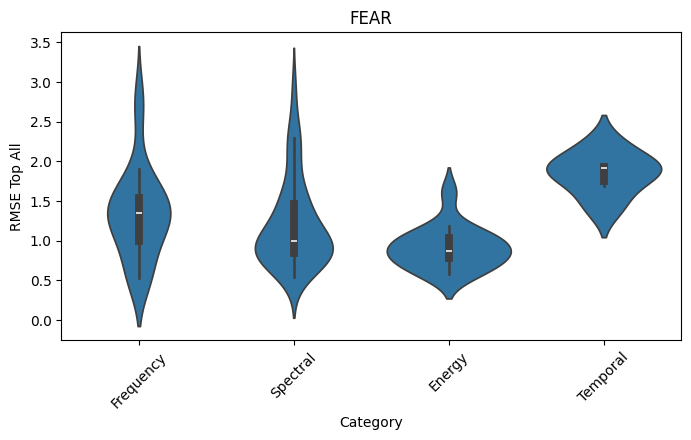

In [ ]:
# Add 'category' column
sorted_df['category'] = sorted_df['Feature'].map(egemaps_category_dict)

# Compute average rmse_top_all for each category
category_avg = sorted_df.groupby('category')['rmse_top_all'].mean().reset_index()

# Plot bar chart
plt.figure(figsize=(8, 4))
sns.barplot(x='category', y='rmse_top_all', data=category_avg)
plt.title('FEAR')
plt.xlabel('Category')
plt.ylabel('Average RMSE Top All')
plt.xticks(rotation=45)
plt.show()

# Plot violin plot
plt.figure(figsize=(8, 4))
sns.violinplot(x='category', y='rmse_top_all', data=sorted_df)
plt.title('FEAR')
plt.xlabel('Category')
plt.ylabel('RMSE Top All')
plt.xticks(rotation=45)
plt.show()

# Compute average rmse_top_all for each category
category_avg = sorted_df.groupby('category')['rmse_top_squared_all'].mean().reset_index()
sorted_df.to_pickle('fear_ravdess_infogain.pkl')

# Plot bar chart
plt.figure(figsize=(8, 4))
sns.barplot(x='category', y='rmse_top_squared_all', data=category_avg)
plt.title('FEAR')
plt.xlabel('Category')
plt.ylabel('Average RMSE Top SQUARED All')
plt.xticks(rotation=45)
plt.show()

# Plot violin plot
plt.figure(figsize=(8, 4))
sns.violinplot(x='category', y='rmse_top_squared_all', data=sorted_df)
plt.title('FEAR')
plt.xlabel('Category')
plt.ylabel('RMSE Top All')
plt.xticks(rotation=45)
plt.show()


## Joy

In [ ]:
df = pd.DataFrame(top_wavlm_predict_ege(emotions[3]))
sorted_df = df.sort_values(by='rmse_top_squared_all', ascending=True)
predicted_df_dict[emotions[3]] = sorted_df


100%|██████████| 88/88 [00:01<00:00, 49.29it/s]


In [ ]:
sorted_df.head(10)

,Feature,rmse_top_all,rmse_top_squared_all,rmse_top,rmse_all,weighted_difference_rmse_all,harmonic_mean_metric_all,change_index_adjusted_performance_all,performance_weighted_change_score_all
66,spectralFluxV_sma3nz_amean,1.459,0.363,0.249,0.171,2.188,1.171,1.137,-0.315
87,equivalentSoundLevel_dBp,1.372,0.382,0.278,0.203,1.548,1.212,1.039,-0.271
3,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,1.076,0.383,0.356,0.331,0.222,1.397,0.754,-0.071
0,F0semitoneFrom27.5Hz_sma3nz_amean,1.281,0.456,0.356,0.278,0.888,1.222,0.898,-0.219
20,spectralFlux_sma3_amean,1.667,0.470,0.282,0.169,2.959,1.026,1.258,-0.400
10,loudness_sma3_amean,1.577,0.474,0.300,0.191,2.350,1.065,1.168,-0.366
16,loudness_sma3_meanRisingSlope,1.726,0.600,0.348,0.202,2.642,0.965,1.219,-0.421
4,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,1.448,0.620,0.428,0.296,1.239,1.066,0.944,-0.310
2,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,1.294,0.639,0.494,0.382,0.672,1.119,0.790,-0.227
14,loudness_sma3_percentile80.0,1.908,0.654,0.343,0.180,3.479,0.889,1.355,-0.476


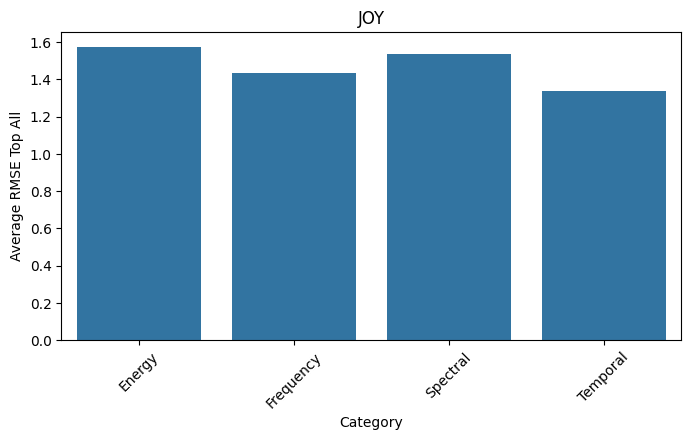

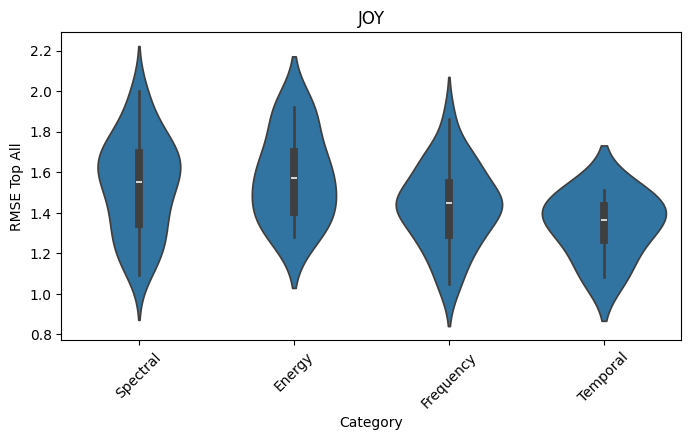

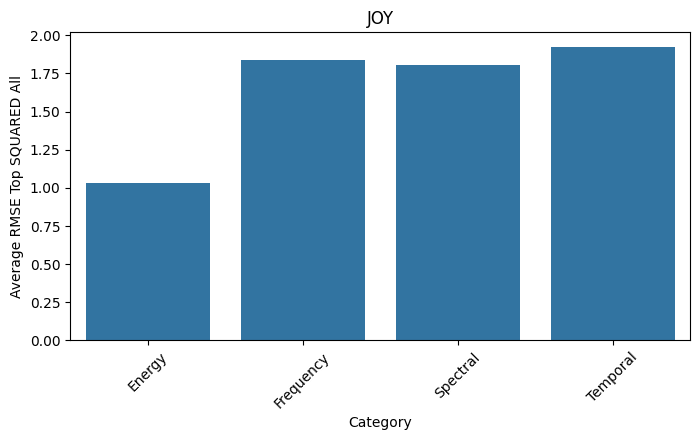

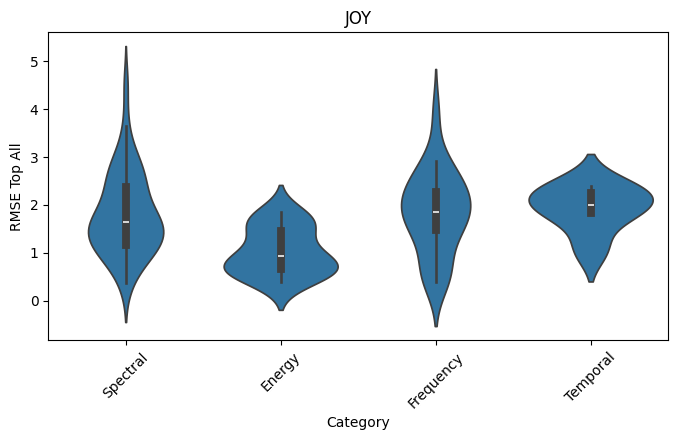

In [ ]:
# Add 'category' column
sorted_df['category'] = sorted_df['Feature'].map(egemaps_category_dict)

# Compute average rmse_top_all for each category
category_avg = sorted_df.groupby('category')['rmse_top_all'].mean().reset_index()

# Plot bar chart
plt.figure(figsize=(8, 4))
sns.barplot(x='category', y='rmse_top_all', data=category_avg)
plt.title('JOY')
plt.xlabel('Category')
plt.ylabel('Average RMSE Top All')
plt.xticks(rotation=45)
plt.show()

# Plot violin plot
plt.figure(figsize=(8, 4))
sns.violinplot(x='category', y='rmse_top_all', data=sorted_df)
plt.title('JOY')
plt.xlabel('Category')
plt.ylabel('RMSE Top All')
plt.xticks(rotation=45)
plt.show()

# Compute average rmse_top_all for each category
category_avg = sorted_df.groupby('category')['rmse_top_squared_all'].mean().reset_index()
sorted_df.to_pickle('joy_ravdess_infogain.pkl')


# Plot bar chart
plt.figure(figsize=(8, 4))
sns.barplot(x='category', y='rmse_top_squared_all', data=category_avg)
plt.title('JOY')
plt.xlabel('Category')
plt.ylabel('Average RMSE Top SQUARED All')
plt.xticks(rotation=45)
plt.show()

# Plot violin plot
plt.figure(figsize=(8, 4))
sns.violinplot(x='category', y='rmse_top_squared_all', data=sorted_df)
plt.title('JOY')
plt.xlabel('Category')
plt.ylabel('RMSE Top All')
plt.xticks(rotation=45)
plt.show()


## Sadness

In [ ]:
df = pd.DataFrame(top_wavlm_predict_ege(emotions[4]))
sorted_df = df.sort_values(by='rmse_top_squared_all', ascending=True)
predicted_df_dict[emotions[4]] = sorted_df


100%|██████████| 88/88 [00:03<00:00, 22.22it/s]


In [ ]:
sorted_df.head(10)

,Feature,rmse_top_all,rmse_top_squared_all,rmse_top,rmse_all,weighted_difference_rmse_all,harmonic_mean_metric_all,change_index_adjusted_performance_all,performance_weighted_change_score_all
66,spectralFluxV_sma3nz_amean,1.248,0.189,0.151,0.121,1.823,1.429,1.073,-0.199
10,loudness_sma3_amean,1.298,0.228,0.176,0.136,1.913,1.357,1.089,-0.229
15,loudness_sma3_pctlrange0-2,1.257,0.236,0.188,0.150,1.521,1.384,1.041,-0.204
14,loudness_sma3_percentile80.0,1.260,0.238,0.189,0.150,1.536,1.381,1.043,-0.206
20,spectralFlux_sma3_amean,1.311,0.249,0.190,0.145,1.852,1.332,1.084,-0.237
16,loudness_sma3_meanRisingSlope,1.247,0.298,0.239,0.192,1.144,1.346,0.981,-0.198
18,loudness_sma3_meanFallingSlope,1.371,0.311,0.227,0.165,1.892,1.252,1.093,-0.271
17,loudness_sma3_stddevRisingSlope,1.199,0.320,0.267,0.223,0.814,1.364,0.918,-0.166
0,F0semitoneFrom27.5Hz_sma3nz_amean,1.174,0.325,0.277,0.236,0.680,1.378,0.890,-0.148
87,equivalentSoundLevel_dBp,1.331,0.355,0.267,0.200,1.419,1.251,1.020,-0.249


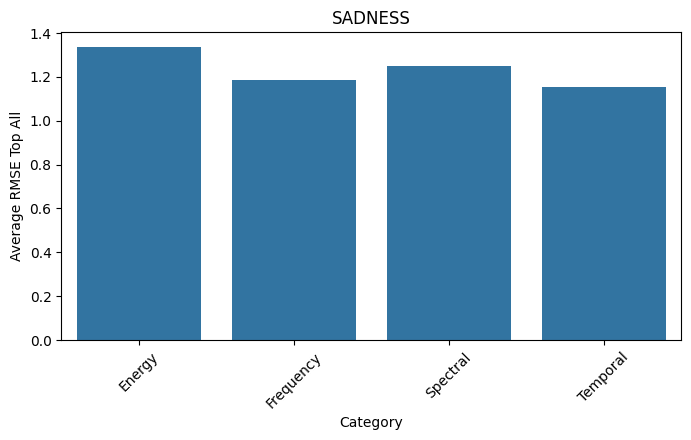

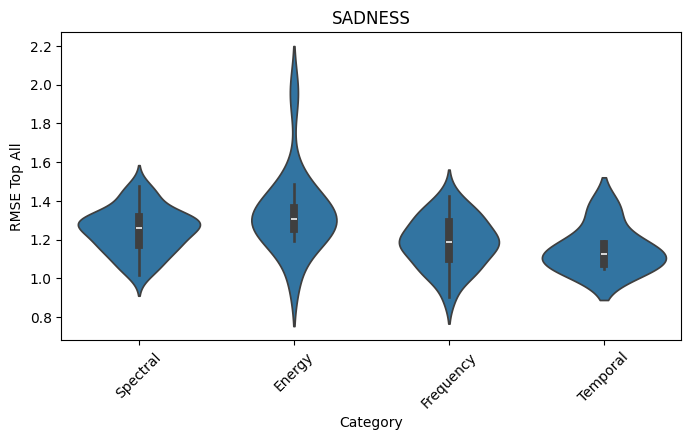

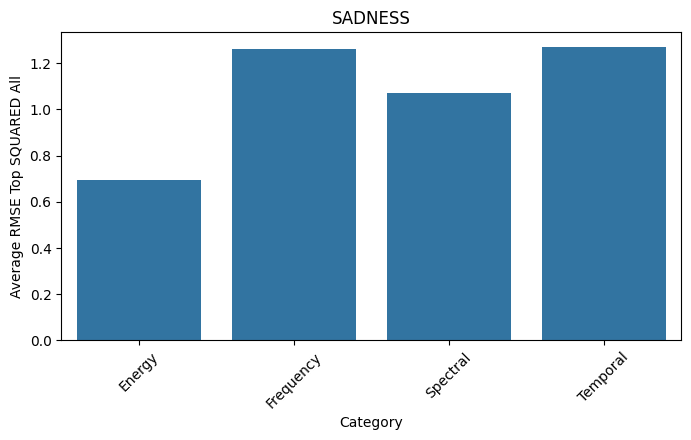

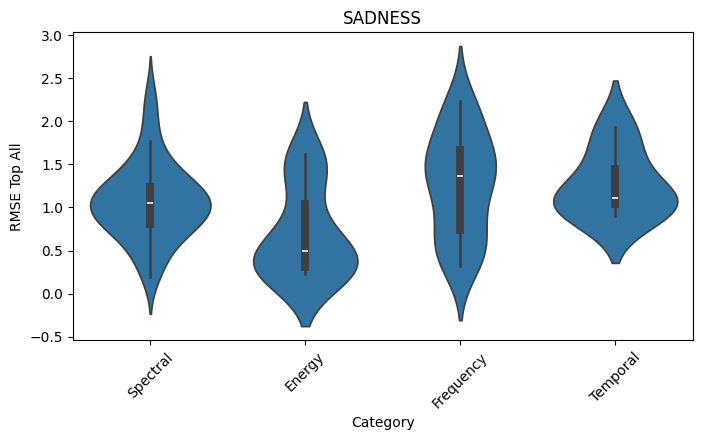

In [ ]:
# Add 'category' column
sorted_df['category'] = sorted_df['Feature'].map(egemaps_category_dict)

# Compute average rmse_top_all for each category
category_avg = sorted_df.groupby('category')['rmse_top_all'].mean().reset_index()

# Plot bar chart
plt.figure(figsize=(8, 4))
sns.barplot(x='category', y='rmse_top_all', data=category_avg)
plt.title('SADNESS')
plt.xlabel('Category')
plt.ylabel('Average RMSE Top All')
plt.xticks(rotation=45)
plt.show()

# Plot violin plot
plt.figure(figsize=(8, 4))
sns.violinplot(x='category', y='rmse_top_all', data=sorted_df)
plt.title('SADNESS')
plt.xlabel('Category')
plt.ylabel('RMSE Top All')
plt.xticks(rotation=45)
plt.show()

# Compute average rmse_top_all for each category
category_avg = sorted_df.groupby('category')['rmse_top_squared_all'].mean().reset_index()
sorted_df.to_pickle('sadness_ravdess_infogain.pkl')

# Plot bar chart
plt.figure(figsize=(8, 4))
sns.barplot(x='category', y='rmse_top_squared_all', data=category_avg)
plt.title('SADNESS')
plt.xlabel('Category')
plt.ylabel('Average RMSE Top SQUARED All')
plt.xticks(rotation=45)
plt.show()

# Plot violin plot
plt.figure(figsize=(8, 4))
sns.violinplot(x='category', y='rmse_top_squared_all', data=sorted_df)
plt.title('SADNESS')
plt.xlabel('Category')
plt.ylabel('RMSE Top All')
plt.xticks(rotation=45)
plt.show()


## Disgust

In [ ]:
df = pd.DataFrame(top_wavlm_predict_ege(emotions[5]))
sorted_df = df.sort_values(by='rmse_top_squared_all', ascending=True)
predicted_df_dict[emotions[5]] = sorted_df


100%|██████████| 88/88 [00:03<00:00, 27.09it/s]


In [ ]:
sorted_df.head(10)

,Feature,rmse_top_all,rmse_top_squared_all,rmse_top,rmse_all,weighted_difference_rmse_all,harmonic_mean_metric_all,change_index_adjusted_performance_all,performance_weighted_change_score_all
66,spectralFluxV_sma3nz_amean,1.157,0.183,0.158,0.137,1.065,1.520,0.988,-0.136
20,spectralFlux_sma3_amean,1.335,0.236,0.177,0.133,2.160,1.323,1.118,-0.251
15,loudness_sma3_pctlrange0-2,1.287,0.336,0.261,0.203,1.240,1.292,0.992,-0.223
14,loudness_sma3_percentile80.0,1.293,0.339,0.263,0.203,1.257,1.286,0.994,-0.226
3,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,1.035,0.347,0.336,0.324,0.107,1.459,0.740,-0.034
16,loudness_sma3_meanRisingSlope,1.548,0.368,0.238,0.154,2.803,1.120,1.221,-0.354
68,mfcc1V_sma3nz_amean,0.964,0.374,0.388,0.402,-0.092,1.480,0.654,0.038
69,mfcc1V_sma3nz_stddevNorm,0.883,0.387,0.439,0.497,-0.251,1.514,0.569,0.133
17,loudness_sma3_stddevRisingSlope,1.223,0.410,0.335,0.274,0.733,1.283,0.875,-0.182
59,alphaRatioV_sma3nz_stddevNorm,0.989,0.417,0.421,0.426,-0.025,1.418,0.649,0.011


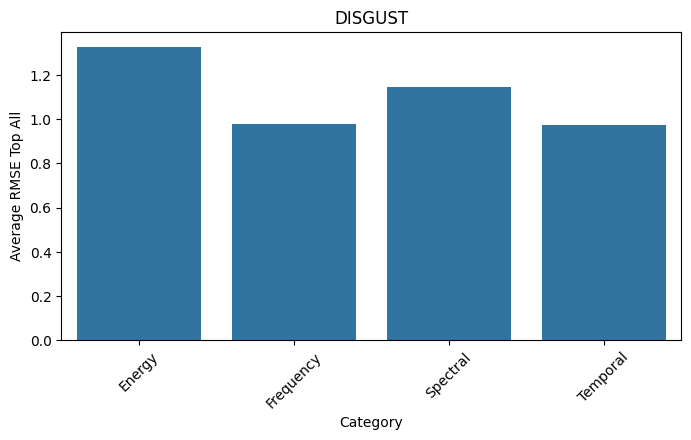

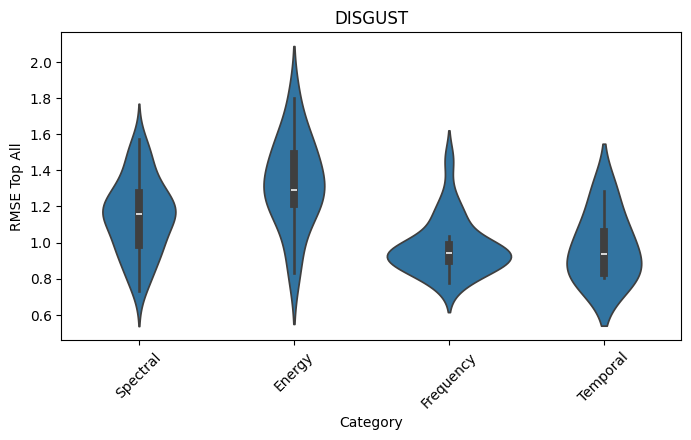

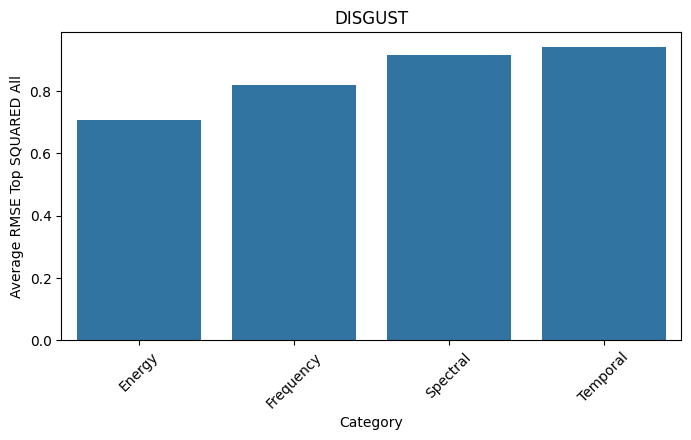

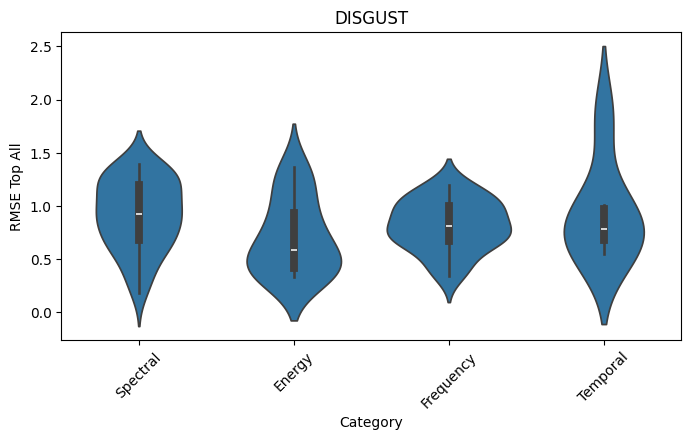

In [ ]:
# Add 'category' column
sorted_df['category'] = sorted_df['Feature'].map(egemaps_category_dict)

# Compute average rmse_top_all for each category
category_avg = sorted_df.groupby('category')['rmse_top_all'].mean().reset_index()

# Plot bar chart
plt.figure(figsize=(8, 4))
sns.barplot(x='category', y='rmse_top_all', data=category_avg)
plt.title('DISGUST')
plt.xlabel('Category')
plt.ylabel('Average RMSE Top All')
plt.xticks(rotation=45)
plt.show()

# Plot violin plot
plt.figure(figsize=(8, 4))
sns.violinplot(x='category', y='rmse_top_all', data=sorted_df)
plt.title('DISGUST')
plt.xlabel('Category')
plt.ylabel('RMSE Top All')
plt.xticks(rotation=45)
plt.show()

# Compute average rmse_top_all for each category
category_avg = sorted_df.groupby('category')['rmse_top_squared_all'].mean().reset_index()
sorted_df.to_pickle('disgust_ravdess_infogain.pkl')


# Plot bar chart
plt.figure(figsize=(8, 4))
sns.barplot(x='category', y='rmse_top_squared_all', data=category_avg)
plt.title('DISGUST')
plt.xlabel('Category')
plt.ylabel('Average RMSE Top SQUARED All')
plt.xticks(rotation=45)
plt.show()

# Plot violin plot
plt.figure(figsize=(8, 4))
sns.violinplot(x='category', y='rmse_top_squared_all', data=sorted_df)
plt.title('DISGUST')
plt.xlabel('Category')
plt.ylabel('RMSE Top All')
plt.xticks(rotation=45)
plt.show()


# SER Performance Summary

In [ ]:
df = pd.DataFrame(Performance)
df

,eGeMAPS,WavLM_all,WavLM_top_features
anger,93.7,97.5,100.0
fear,90.9,99.3,100.0
neutrality,0.0,0.0,0.0
joy,84.0,91.8,99.4
sadness,75.7,87.2,96.6
disgust,89.9,98.7,100.0
